# Прогнозирование восстановления золота из руды

Компания «Цифра» разрабатывает решения для эффективной работы промышленных предприятий.
Ее клиенту, предприятию, занимающемуся добычей и очисткой золотоносной руды, необходимо оптимизировать производство, чтобы не запускать процессы с убыточными характеристиками.

**Задача:** Спрогнозировать коэффициент восстановления золота из руды с помощью модели машинного обучения.<br>
Качество модели необходимо оценить по метрике sMAPE, симметричному среднему абсолютному процентному отклонению (Symmetric Mean Absolute Percentage Error).

**Описание получения золота из руды**

Добытая руда проходит первичную обработку, затем её отправляют на флотацию (обогащение) и двухэтапную очистку.
1. Флотация
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. Очистка
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

Этапы обработки
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

Возможные значения для блока [тип_параметра]:<br>
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

**Описание данных**

Данные разделены на три датасета - исходный, обучающий и тестовый.

Имеется информация об исходном сырье и с данными после его очистки. Данные индексируются датой и временем получения информации (признак date). Показатели соседних партий обычно схожи.

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate — ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

*Наименование признаков*<br>
[этап].[тип_параметра].[название_параметра]<br>
Пример: rougher.input.feed_ag

*Особенности:*<br>
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-и-подготовка-данных" data-toc-modified-id="Обзор-и-подготовка-данных-1">Обзор и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Проверка-рассчетов" data-toc-modified-id="Проверка-рассчетов-1.1">Проверка рассчетов</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2">Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Анализ-признаков-и-их-взаимодействий" data-toc-modified-id="Анализ-признаков-и-их-взаимодействий-2.1">Анализ признаков и их взаимодействий</a></span><ul class="toc-item"><li><span><a href="#Целевые-признаки-и-доли-золота-в-разных-субстратах" data-toc-modified-id="Целевые-признаки-и-доли-золота-в-разных-субстратах-2.1.1">Целевые признаки и доли золота в разных субстратах</a></span></li><li><span><a href="#Размер-гранул-сырья-и-скорость-их-подачи" data-toc-modified-id="Размер-гранул-сырья-и-скорость-их-подачи-2.1.2">Размер гранул сырья и скорость их подачи</a></span></li><li><span><a href="#Флотационные-реагенты" data-toc-modified-id="Флотационные-реагенты-2.1.3">Флотационные реагенты</a></span></li><li><span><a href="#Физические-параметры" data-toc-modified-id="Физические-параметры-2.1.4">Физические параметры</a></span></li><li><span><a href="#Доля-металлов-в-руде" data-toc-modified-id="Доля-металлов-в-руде-2.1.5">Доля металлов в руде</a></span></li></ul></li><li><span><a href="#Изменение-концентрации-металлов-на-различных-этапах" data-toc-modified-id="Изменение-концентрации-металлов-на-различных-этапах-2.2">Изменение концентрации металлов на различных этапах</a></span></li><li><span><a href="#Обработка-аномальных-значений" data-toc-modified-id="Обработка-аномальных-значений-2.3">Обработка аномальных значений</a></span></li><li><span><a href="#Обработка-пропущенных-значений" data-toc-modified-id="Обработка-пропущенных-значений-2.4">Обработка пропущенных значений</a></span></li></ul></li><li><span><a href="#Исследование-моделей" data-toc-modified-id="Исследование-моделей-3">Исследование моделей</a></span><ul class="toc-item"><li><span><a href="#Прогноз-коэффициента-обогащения-чернового-концентрата" data-toc-modified-id="Прогноз-коэффициента-обогащения-чернового-концентрата-3.1">Прогноз коэффициента обогащения чернового концентрата</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1.1">Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.1.2">Случайный лес</a></span></li><li><span><a href="#Cлучайная-модель" data-toc-modified-id="Cлучайная-модель-3.1.3">Cлучайная модель</a></span></li></ul></li><li><span><a href="#Прогноз-коэффициента-обогащения-финального-продукта" data-toc-modified-id="Прогноз-коэффициента-обогащения-финального-продукта-3.2">Прогноз коэффициента обогащения финального продукта</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2.1">Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2.2">Случайный лес</a></span></li><li><span><a href="#Cлучайная-модель" data-toc-modified-id="Cлучайная-модель-3.2.3">Cлучайная модель</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование-моделей" data-toc-modified-id="Тестирование-моделей-4">Тестирование моделей</a></span><ul class="toc-item"><li><span><a href="#Предсказание-коэффициента-обогащения-для-чернового-концентрата" data-toc-modified-id="Предсказание-коэффициента-обогащения-для-чернового-концентрата-4.1">Предсказание коэффициента обогащения для чернового концентрата</a></span></li><li><span><a href="#Предсказание-коэффициента-обогащения-для-финального-продукта" data-toc-modified-id="Предсказание-коэффициента-обогащения-для-финального-продукта-4.2">Предсказание коэффициента обогащения для финального продукта</a></span></li><li><span><a href="#Итоговая-метрика" data-toc-modified-id="Итоговая-метрика-4.3">Итоговая метрика</a></span></li></ul></li><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-5">Общий вывод:</a></span></li></ul></div>

In [1]:
#!pip install phik

In [2]:
# import libraries 
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from phik.report import correlation_report, plot_correlation_matrix

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [3]:
# display settings
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', 100)
pd.set_option("display.precision", 4)

%matplotlib inline

## Обзор и подготовка данных

Из описания данных известно, что признак `date` - дата и время получения информации, при чтении файла приведем его сразу в формат datetime.

In [4]:
# data path
path = os.path.join(os.path.dirname(os.getcwd()), '9_Project2')

In [5]:
# define function to read files and display information about the data
def read_file(dataset_type):
    """ Функция принимает строку - 
    тип датасета (full, train, tast).
    Читает данные, выводит основную информацию
    по файлу, возвращает датафрейм с данными"""
    
    # reading files
    filename = 'gold_recovery_' + dataset_type + '_new.csv'
    try:
        df = pd.read_csv(os.path.join(path, filename), 
                         parse_dates=['date'])
    except:
        df = pd.read_csv('/datasets/'+filename, 
                         parse_dates=['date'])
        
    # get first and last 5 rows
    display(df)
    
    # get information about the data
    print()
    print(df.info())
    
    # check for duplicates
    print()
    if df.duplicated().sum() > 0:
        print('В данных есть явные дубликаты')
    else:
        print('В данных нет явных дубликатов')
    
    # check for NaN
    if df.isna().sum().sum() > 0:
        print('В данных есть пропущенные значения')
    else:
        print('В данных нет пропущенных значений')
    
    return df

In [6]:
# complete data
data_full = read_file('full')

date  final.output.concentrate_ag  \
0     2016-01-15 00:00:00                       6.0554   
1     2016-01-15 01:00:00                       6.0294   
2     2016-01-15 02:00:00                       6.0559   
3     2016-01-15 03:00:00                       6.0480   
4     2016-01-15 04:00:00                       6.1486   
...                   ...                          ...   
19434 2018-08-18 06:59:59                       3.2249   
19435 2018-08-18 07:59:59                       3.1960   
19436 2018-08-18 08:59:59                       3.1100   
19437 2018-08-18 09:59:59                       3.3672   
19438 2018-08-18 10:59:59                       3.5984   

       final.output.concentrate_pb  final.output.concentrate_sol  \
0                           9.8896                        5.5073   
1                           9.9689                        5.2578   
2                          10.2140                        5.3838   
3                           9.9770                        4.8586   
4                          10.1425                        4.9394   
...                            ...                           ...   
19434                      11.3562                        6.8035   
19435                      11.3494                        6.8622   
19436                      11.4344                        6.8860   
19437                      11.6256                        6.7994   
19438                      11.7378                        6.7175   

       final.output.concentrate_au  final.output.recovery  \
0                          42.1920                70.5412   
1                          42.7016                69.2662   
2                          42.6575                68.1164   
3                          42.6898                68.3475   
4                          42.7741                66.9270   
...                            ...                    ...   
19434                      46.7140                73.7551   
19435                      46.8668                69.0493   
19436                      46.7957                67.0022   
19437                      46.4082                65.5232   
19438                      46.2994                70.2815   

       final.output.tail_ag  final.output.tail_pb  final.output.tail_sol  \
0                   10.4120                0.8954                16.9043   
1                   10.4627                0.9275                16.6345   
2                   10.5070                0.9537                16.2088   
3                   10.4228                0.8838                16.5328   
4                   10.3603                0.7928                16.5257   
...                     ...                   ...                    ...   
19434                8.7696                3.1415                10.4032   
19435                8.8973                3.1305                10.5495   
19436                8.5296                2.9114                11.1151   
19437                8.7772                2.8192                10.4638   
19438                8.4067                2.5175                10.6522   

       final.output.tail_au  primary_cleaner.input.sulfate  \
0                    2.1431                       127.0920   
1                    2.2249                       125.6292   
2                    2.2579                       123.8198   
3                    2.1468                       122.2702   
4                    2.0553                       117.9882   
...                     ...                            ...   
19434                1.5292                       123.3818   
19435                1.6125                       120.8782   
19436                1.5966                       105.6661   
19437                1.6029                        98.8805   
19438                1.3894                        95.2484   

       primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                               10.1283 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         19438 non-null  float64       
 2   final.output.concentrate_pb                         19438 non-null  float64       
 3   final.output.concentrate_sol                        19228 non-null  float64       
 4   final.output.concentrate_au                         19439 non-null  float64       
 5   final.output.recovery                               19439 non-null  float64       
 6   final.output.tail_ag                                19438 non-null  float64       
 7   final.output.tail_pb                                19338 non-null  float64       
 8   final

In [7]:
# train data
data_train = read_file('train')

date  final.output.concentrate_ag  \
0     2016-01-15 00:00:00                       6.0554   
1     2016-01-15 01:00:00                       6.0294   
2     2016-01-15 02:00:00                       6.0559   
3     2016-01-15 03:00:00                       6.0480   
4     2016-01-15 04:00:00                       6.1486   
...                   ...                          ...   
14144 2018-08-18 06:59:59                       3.2249   
14145 2018-08-18 07:59:59                       3.1960   
14146 2018-08-18 08:59:59                       3.1100   
14147 2018-08-18 09:59:59                       3.3672   
14148 2018-08-18 10:59:59                       3.5984   

       final.output.concentrate_pb  final.output.concentrate_sol  \
0                           9.8896                        5.5073   
1                           9.9689                        5.2578   
2                          10.2140                        5.3838   
3                           9.9770                        4.8586   
4                          10.1425                        4.9394   
...                            ...                           ...   
14144                      11.3562                        6.8035   
14145                      11.3494                        6.8622   
14146                      11.4344                        6.8860   
14147                      11.6256                        6.7994   
14148                      11.7378                        6.7175   

       final.output.concentrate_au  final.output.recovery  \
0                          42.1920                70.5412   
1                          42.7016                69.2662   
2                          42.6575                68.1164   
3                          42.6898                68.3475   
4                          42.7741                66.9270   
...                            ...                    ...   
14144                      46.7140                73.7551   
14145                      46.8668                69.0493   
14146                      46.7957                67.0022   
14147                      46.4082                65.5232   
14148                      46.2994                70.2815   

       final.output.tail_ag  final.output.tail_pb  final.output.tail_sol  \
0                   10.4120                0.8954                16.9043   
1                   10.4627                0.9275                16.6345   
2                   10.5070                0.9537                16.2088   
3                   10.4228                0.8838                16.5328   
4                   10.3603                0.7928                16.5257   
...                     ...                   ...                    ...   
14144                8.7696                3.1415                10.4032   
14145                8.8973                3.1305                10.5495   
14146                8.5296                2.9114                11.1151   
14147                8.7772                2.8192                10.4638   
14148                8.4067                2.5175                10.6522   

       final.output.tail_au  primary_cleaner.input.sulfate  \
0                    2.1431                       127.0920   
1                    2.2249                       125.6292   
2                    2.2579                       123.8198   
3                    2.1468                       122.2702   
4                    2.0553                       117.9882   
...                     ...                            ...   
14144                1.5292                       123.3818   
14145                1.6125                       120.8782   
14146                1.5966                       105.6661   
14147                1.6029                        98.8805   
14148                1.3894                        95.2484   

       primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                               10.1283 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14149 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         14148 non-null  float64       
 2   final.output.concentrate_pb                         14148 non-null  float64       
 3   final.output.concentrate_sol                        13938 non-null  float64       
 4   final.output.concentrate_au                         14149 non-null  float64       
 5   final.output.recovery                               14149 non-null  float64       
 6   final.output.tail_ag                                14149 non-null  float64       
 7   final.output.tail_pb                                14049 non-null  float64       
 8   final

In [8]:
# test data
data_test = read_file('test')

date  primary_cleaner.input.sulfate  \
0    2016-09-01 00:59:59                       210.8009   
1    2016-09-01 01:59:59                       215.3925   
2    2016-09-01 02:59:59                       215.2599   
3    2016-09-01 03:59:59                       215.3362   
4    2016-09-01 04:59:59                       199.0993   
...                  ...                            ...   
5285 2017-12-31 19:59:59                       173.9578   
5286 2017-12-31 20:59:59                       172.9103   
5287 2017-12-31 21:59:59                       171.1357   
5288 2017-12-31 22:59:59                       179.6972   
5289 2017-12-31 23:59:59                       181.5569   

      primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                              14.9931                           8.0800   
1                              14.9875                           8.0800   
2                              12.8849                           7.7867   
3                              12.0068                           7.6400   
4                              10.6825                           7.5300   
...                                ...                              ...   
5285                           15.9634                           8.0700   
5286                           16.0026                           8.0700   
5287                           15.9937                           8.0700   
5288                           15.4390                           8.0700   
5289                           14.9958                           8.0700   

      primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                             1.0050                               1398.9813   
1                             0.9905                               1398.7779   
2                             0.9960                               1398.4937   
3                             0.8635                               1399.6181   
4                             0.8056                               1401.2681   
...                              ...                                     ...   
5285                          0.8967                               1401.9306   
5286                          0.8965                               1447.0757   
5287                          1.1660                               1498.8362   
5288                          1.5011                               1498.4662   
5289                          1.6235                               1498.0963   

      primary_cleaner.state.floatbank8_a_level  \
0                                    -500.2256   
1                                    -500.0574   
2                                    -500.8684   
3                                    -498.8636   
4                                    -500.8083   
...                                        ...   
5285                                 -499.7288   
5286                                 -494.7168   
5287                                 -501.7704   
5288                                 -500.4840   
5289                                 -499.7969   

      primary_cleaner.state.floatbank8_b_air  \
0                                  1399.1449   
1                                  1398.0554   
2                                  1398.8604   
3                                  1397.4401   
4                                  1398.1288   
...                                      ...   
5285                               1401.4414   
5286                               1448.8519   
5287                               1499.5724   
5288                               1497.9870   
5289                               1501.7438   

      primary_cleaner.state.floatbank8_b_level  \
0                                    -499.9197   
1                                    -499.7782   
2                                    -499.7645   
3                                    -499.2110   
4                    


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5290 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5286 non-null   float64       
 2   primary_cleaner.input.depressant            5285 non-null   float64       
 3   primary_cleaner.input.feed_size             5290 non-null   float64       
 4   primary_cleaner.input.xanthate              5286 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64       
 9   primary

Посмотрим, какие данные были выделены для теста модели, а какие для обучения.

In [9]:
# percentage of data for test
f'Процент данных для теста: {len(data_test) / len(data_full):.0%}'

'Процент данных для теста: 27%'

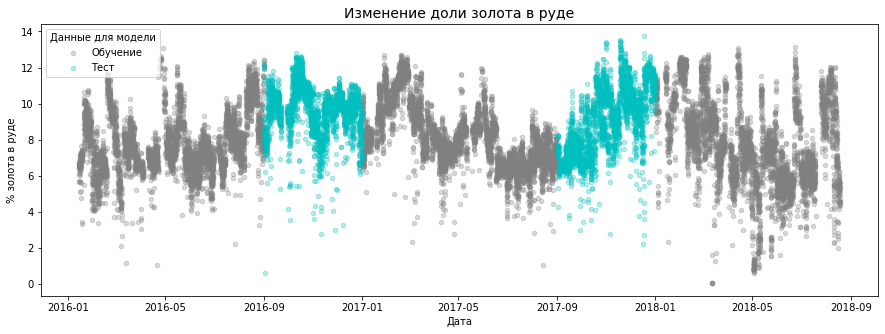

In [10]:
# train and test data
ax=data_train.plot(x='date', 
                y='rougher.input.feed_au',
                kind='scatter', c='gray', alpha=0.3, figsize=(15,5), label='Обучение')
data_test.plot(x='date', 
               y='rougher.input.feed_au',
               kind='scatter', c='c', alpha=0.3, label='Тест', ax=ax)

plt.xlabel('Дата')
plt.ylabel('% золота в руде')
plt.legend(title='Данные для модели', loc='upper left')
plt.title('Изменение доли золота в руде', fontsize=14)
plt.show()

*Вывод:* В данных более 19 000 записей (партий обработки руды) без явных дубликатов с параметрами исходной руды, флотации и очистки за три года, с 2016 по 2018. В некоторых признаках есть пропуски. Данные разделены на обучающую и тестовую выборки в соотношении 73% к 27%. Для обучающей выборки взяты данные каждого кода, примерно одних и тех же месяцев, а вот для тестовой выборки взяты два периода - с конец 2016 и 2017 годов (примерно с сентября по январь).

Сравним обучающую и тестовую выборки на примере распределения размеров гранул сырья. Если распределения будут сильно отличаться друг от друга, оценка модели может быть неправильной и стоит переразбить данные на выборки.

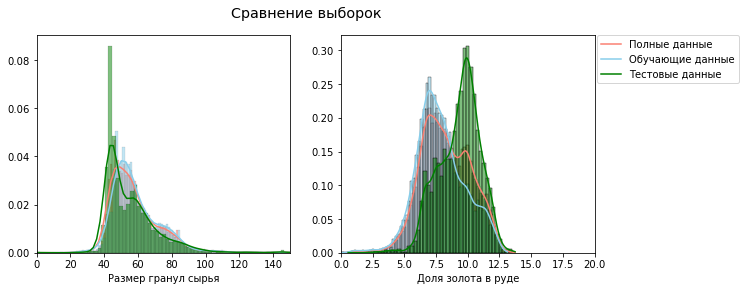

In [11]:
# distribution histograms of feed sizes and au concentrations
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Сравнение выборок", fontsize="x-large")

sns.histplot(data=data_full, x='rougher.input.feed_size', kde=True, stat= 'density', 
             color="salmon", ax=axs[0])
sns.histplot(data=data_train, x='rougher.input.feed_size', kde=True, stat= 'density',
             color="skyblue", ax=axs[0])
sns.histplot(data=data_test, x='rougher.input.feed_size', kde=True, stat= 'density',
             color="green", ax=axs[0]).set(xlabel='Размер гранул сырья', 
                                           ylabel=None, xlim=(0, 150))

sns.histplot(data=data_full, x='rougher.input.feed_au', kde=True, stat= 'density',
             color="salmon", ax=axs[1])
sns.histplot(data=data_train, x='rougher.input.feed_au', kde=True, stat= 'density',
             color="skyblue", ax=axs[1])
sns.histplot(data=data_test, x='rougher.input.feed_au', kde=True, stat= 'density',
             color="green", ax=axs[1]).set(xlabel='Доля золота в руде', 
                                           ylabel=None, xlim=(0, 20))

plt.legend(labels=["Полные данные",
                   "Обучающие данные",
                   "Тестовые данные"], 
           bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()

*Вывод:* Судя по распределению размеров гранул сырья и количеству золота в руде, обучающая выборка очень похожа на весь набор данных. Тестовая выборка несколько отличается - для размера гранул она больше скошена вправо, а для распределения концентрации золота - влево. При этом в тестовой выборке преобладают значение с более высоким содержанием золота, по сравнению с обучающей выборкой. Тем не менее, диапазон значений схож и, так как мы имеем "фиксированное" разделение на тестовую и обучающую выборки, оставим их как есть.

Известно, что в тестовой выборке отсутствуют некоторые признаки, так как для прогнозирования целевых переменных нам доступны лишь "входные" данные, а некоторые параметры замеряются и/или рассчитываются значительно позже. В тестовых данных 53 признака, а в обучающих и исходных - 87, включая целевые.
Посмотрим, каких признаков нет в тестовых данных. 

In [12]:
# features unavalable in the test data
set(data_train) - set(data_test)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовых данных, как и ожидалось, отсутствуют все "выходные" данные каждой технологической стадии процесса и рассчеты на их основе. Такие же переменные стоит оставить и в обучающей выборке.

Добавим в тестовые данные целевые переменные `rougher.output.recovery` и `final.output.recovery` и удалим из обучающего сета признаки, которых нет в тестовом.

In [13]:
# add targets to the test dataset
data_test = data_test.merge(
    data_full[
        ['date', 'rougher.output.recovery', 'final.output.recovery']], 
    on='date', how='left')
data_test.shape

(5290, 55)

In [14]:
# drop "output" features from the train dataset
data_train = data_train[list(data_test)]
data_train.shape

(14149, 55)

Теперь для подготовки модели у нас есть обучающая и тестовая выборки с одинаковыми столбцами. В данных имеются пропуски, которые перед обучением моделей стоит обработать. Обработку пропусков и возможных выбросов проведем после исседовательского анализа данных.

### Проверка рассчетов

Перед обучением модели стоит проверить, правильно ли в данных рассчитаны целевые переменные `rougher.output.recovery` и `final.output.recovery`, так как от этого будет зависеть результат. 

**Расчёт эффективности**

Эффективность обогащения рассчитывается по формуле

$$Recovery = C * (F - T) / (F * (C - T)) * 100\%$$ 

где:
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

Создадим функцию для рассчета коэффициента восстановления.

In [15]:
# function for calculation of Recovery
def recovery(df, c, f, t):
    """Функция рассчитывает эффективность обогащения.
    Принимает на вход: 
    df - датафрейм; 
    с — строку с названием столбца с долей золота в концентрате 
    ПОСЛЕ флотации/очистки;
    f — строку с названием столбца с долей золота в сырье/концентрате 
    ДО флотации/очистки;
    t — строку с названием столбца с долей золота в отвальных хвостах 
    после флотации/очистки.
    Возвращает pd.Series c коэффициентами эффективности обогащения.
    """
    rec = (df[c] * (df[f]-df[t])
           .div(df[f]*(df[c]-df[t]))
           .mul(100))
    return rec

In [16]:
# calculation of recovery after rougher process
rec_rougher = recovery(data_full,
                       'rougher.output.concentrate_au',
                       'rougher.input.feed_au',
                       'rougher.output.tail_au')

In [17]:
# calculation of final Recovery
rec_final = recovery(data_full,
                     'final.output.concentrate_au',
                     'rougher.input.feed_au',
                     'final.output.tail_au')

In [18]:
print('Средний коэффициент эффективности обогащения:')
print()
print('Черновой концентрат:')
print(f'Рассчеты {rec_rougher.mean():.2f}')
print(f'Данные {data_full["rougher.output.recovery"].mean():.2f}')
print(f'MAE: {mean_absolute_error(data_full["rougher.output.recovery"], rec_rougher):.4f}')
print()
print('Финальный продукт:')
print(f'Рассчеты {rec_final.mean():.2f}')
print(f'Данные {data_full["final.output.recovery"].mean():.2f}')
print(f'MAE: {mean_absolute_error(data_full["final.output.recovery"], rec_final):.4f}')

Средний коэффициент эффективности обогащения:

Черновой концентрат:
Рассчеты 83.33
Данные 83.33
MAE: 0.0000

Финальный продукт:
Рассчеты 67.05
Данные 67.05
MAE: 0.0000


**Вывод**: целевые переменные в данных рассчитаны верно. Ошибка практически нулевая. Коэффициент эффективности обогащения для чернового концентрата составляет 83%, а для всего процесса - 67%.

## Исследовательский анализ данных

### Анализ признаков и их взаимодействий

Анализ данных проведем на целом датасете. Посмотрим, как различные признаки на разных стадиях влияют друг на друга и на целевые переменные.

#### Целевые признаки и доли золота в разных субстратах

Целевыми переменными являются рассчитанные коэффициенты эффективности обогащения для чернового концентрата `rougher.output.recovery` и для всего процесса `final.output.recovery`.
Данные переменные зависят от доли золота в черновом концентрате/финальном концентрате, доли золота в руде и отвальных хвостах. 

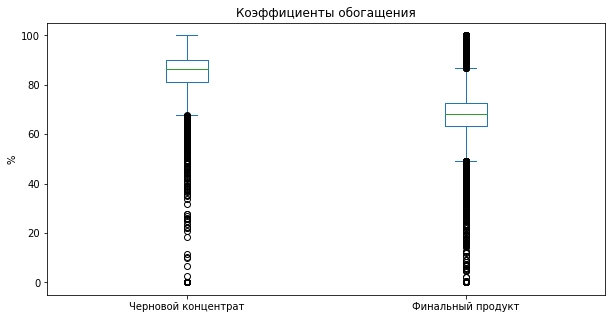

rougher.output.recovery  final.output.recovery
count               19439.0000             19439.0000
mean                   83.3286                67.0502
std                    14.1481                10.1258
min                     0.0000                 0.0000
25%                    81.0380                63.2997
50%                    86.1889                68.1727
75%                    90.0107                72.6866
max                   100.0000               100.0000

In [19]:
# boxplots
data_full[['rougher.output.recovery', 'final.output.recovery']].plot(
    kind='box', title='Коэффициенты обогащения', figsize=(10,5))
plt.ylabel('%')
plt.xticks([1,2], ['Черновой концентрат', 'Финальный продукт'])
plt.show()

#descriptive statistics
data_full[['rougher.output.recovery', 'final.output.recovery']].describe()

Коэффициент обогащения чернового концентрата в среднем составляет около 80%, для большинства случаев (трех четвертей) не превышает 90%. Для финального продукта эти цифры составляют 67% и 73% соответсвенно.

В целевых переменных `rougher.output.recovery` и `final.output.recovery` есть нулевые значения, что говорит о том, что были нулевые значения доли золота в черновом концентрате или финальном концентратах (в руде не было нулевых значений доли золота).  Проанализируем эти значения, посмотрим для них на содержание золота и других металлов в руде и после флотации/очистки. Причина может быть в незаполнении этих показателей по каким-либо технологическим причинам, поскольку количество золота в руде ненулевое во всех случаях.

Также есть значения 100% восстановления золота, что странно, стоит их также проанализировать.

*Нулевые значения коэффициентов обогащения*

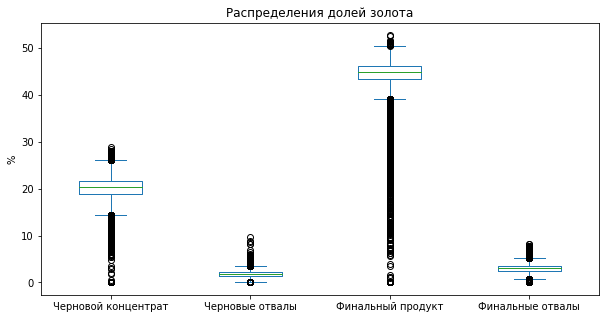

rougher.output.concentrate_au  rougher.output.tail_au  \
count                     19439.0000              19439.0000   
mean                         19.7720                  1.8164   
std                           3.7536                  0.6800   
min                           0.0000                  0.0207   
25%                          18.8025                  1.4042   
50%                          20.2802                  1.8082   
75%                          21.7178                  2.2119   
max                          28.8245                  9.6890   

       final.output.concentrate_au  final.output.tail_au  
count                   19439.0000            19439.0000  
mean                       44.0765                3.0425  
std                         5.1298                0.9228  
min                         0.0000                0.0000  
25%                        43.4022                2.4611  
50%                        45.0112                2.9849  
75%                        46.2753                3.5714  
max                        52.7566                8.2450

In [20]:
# boxplots
data_full[['rougher.output.concentrate_au', 
           'rougher.output.tail_au',
           'final.output.concentrate_au',
           'final.output.tail_au']].plot(
    kind='box', title='Распределения долей золота', figsize=(10,5))
plt.ylabel('%')
plt.xticks([1,2,3,4], ['Черновой концентрат', 
                       'Черновые отвалы', 
                       'Финальный продукт', 
                       'Финальные отвалы'])
plt.show()

data_full[['rougher.output.concentrate_au', 
           'rougher.output.tail_au',
           'final.output.concentrate_au',
           'final.output.tail_au']].describe()

Видно, что как в черновом, так и в финальном концентрате имеются нулевые значения доли золота, это, вероятно, является причиной нулевых значений коэффициентов восстановления. Сначала посмотрим на такие значения в **черновом концентрате**.

In [21]:
print('Процент данных с нулевым содержанием золота в черновом концентрате:')
print(f'{len(data_full[data_full["rougher.output.concentrate_au"] < 0.001])/len(data_full):.2%}')

Процент данных с нулевым содержанием золота в черновом концентрате:
2.03%


Посмотрим на другие признаки при "нулевых" концентрациях золота в черновом концентрате.

In [22]:
# [Au]=0 in rougher_output
data_full[data_full['rougher.output.concentrate_au'] < 0.001][['rougher.input.feed_au', 
                                                               'rougher.output.concentrate_au',
                                                               'rougher.output.tail_au',
                                                               'rougher.output.recovery']]

rougher.input.feed_au  rougher.output.concentrate_au  \
45                    7.1141                            0.0   
46                    7.6515                            0.0   
47                    5.5877                            0.0   
48                    4.7530                            0.0   
49                    5.1228                            0.0   
...                      ...                            ...   
15620                 7.9511                            0.0   
15621                 8.7158                            0.0   
15622                 9.0261                            0.0   
15623                 8.7524                            0.0   
15624                 8.4676                            0.0   

       rougher.output.tail_au  rougher.output.recovery  
45                     1.9398                      0.0  
46                     2.0876                      0.0  
47                     2.1265                      0.0  
48                     1.9389                      0.0  
49                     2.0509                      0.0  
...                       ...                      ...  
15620                  0.7419                      0.0  
15621                  0.8280                      0.0  
15622                  1.0514                      0.0  
15623                  1.0643                      0.0  
15624                  1.0667                      0.0  

[394 rows x 4 columns]

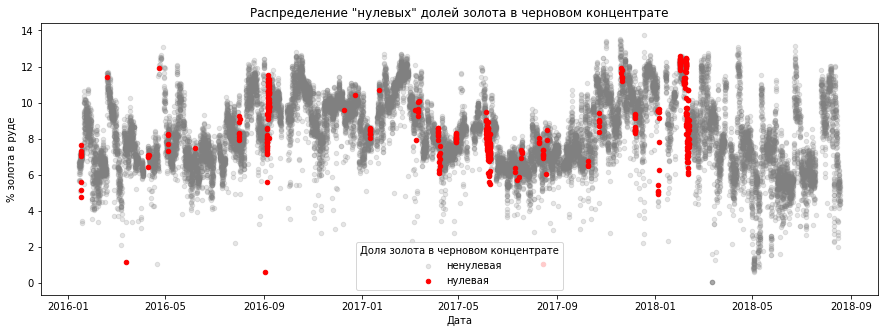

In [23]:
# [Au]=0 in rougher_output, time distribution
ax = data_full.plot(x='date', 
                    y='rougher.input.feed_au',
                    kind='scatter', c='gray', alpha=0.2, figsize=(15,5), label='ненулевая')
data_full[data_full['rougher.output.concentrate_au'] < 0.001].plot(
    x='date', y='rougher.input.feed_au', kind='scatter', c='r', ax=ax,
    label='нулевая')

plt.xlabel('Дата')
plt.ylabel('% золота в руде')
plt.legend(title='Доля золота в черновом концентрате')
plt.title('Распределение "нулевых" долей золота в черновом концентрате')
plt.show()

Нулевые значения количества золота (2% данных) в черновом концентрате, вероятно, обусловлены какими-то технологическими ошибками, видно, что они появляются в основном "кластерами", и при этом количество золота в руде и отвальных хвостах ненулевое. Эти ошибки вызывают появление нулевых значений коэффициента обогащения, которые стоит обработать.

Можно видеть, что и у **финального коэффициента** обогащения есть нулевые значения, причиной этого также могут быть нулевые значения финальной концентрации золота. Проверим это. 

In [24]:
print('Процент данных с нулевой концентрацией золота на финальной стадии:')
print(f'{len(data_full[data_full["final.output.concentrate_au"] < 0.001])/len(data_full):.2%}')

Процент данных с нулевой концентрацией золота на финальной стадии:
0.50%


In [25]:
# [Au]=0 in final.output
data_full[data_full['final.output.concentrate_au'] < 0.001][['rougher.input.feed_au', 
                                                             'final.output.concentrate_au',
                                                             'final.output.tail_au',
                                                             'rougher.output.recovery',
                                                             'final.output.recovery']]

rougher.input.feed_au  final.output.concentrate_au  \
644                   5.5990                          0.0   
1193                  7.7861                          0.0   
1194                  7.4992                          0.0   
1195                  7.0323                          0.0   
1196                  7.0216                          0.0   
...                      ...                          ...   
14951                11.6048                          0.0   
14952                11.7636                          0.0   
15183                 7.3455                          0.0   
15184                 7.6878                          0.0   
15310                 6.0094                          0.0   

       final.output.tail_au  rougher.output.recovery  final.output.recovery  
644                  1.7791                  68.9610                    0.0  
1193                 2.9845                  82.7873                    0.0  
1194                 2.7473                  83.5153                    0.0  
1195                 2.7914                  83.7022                    0.0  
1196                 2.6821                  84.8368                    0.0  
...                     ...                      ...                    ...  
14951                5.0618                  79.7052                    0.0  
14952                4.2916                  83.3258                    0.0  
15183                5.8195                  26.9599                    0.0  
15184                3.8373                  78.7868                    0.0  
15310                1.2109                  65.0039                    0.0  

[98 rows x 5 columns]

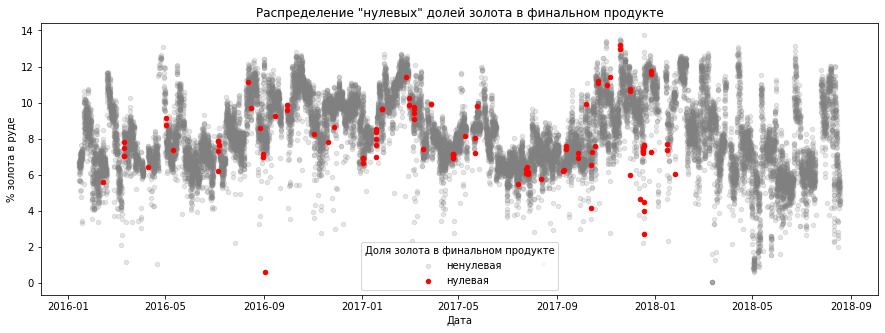

In [26]:
# [Au]=0 in final.output, time distribution
ax = data_full.plot(x='date', 
                    y='rougher.input.feed_au',
                    kind='scatter', c='gray', alpha=0.2, 
                    figsize=(15,5), label='ненулевая')
data_full[data_full['final.output.concentrate_au'] < 0.001].plot(
    x='date', y='rougher.input.feed_au', kind='scatter', c='r', 
    ax=ax, label='нулевая')

plt.xlabel('Дата')
plt.ylabel('% золота в руде')
plt.legend(title='Доля золота в финальном продукте')
plt.title('Распределение "нулевых" долей золота в финальном продукте')
plt.show()

Нулевые значения количества золота в финальном продукте (0.5% данных) разбросаны по всем данным и, вероятно, также обусловлены какими-то технологическими ошибками. При этом количество золота в руде и отвальных хвостах ненулевое. Эти ошибки вызывают появление нулевых значений финального коэффициента обогащения, которые стоит обработать перед обучением модели.

*100% коэффициенты обогащения*

Имеются значения коэффициентов обогащения, равные 100%, что также подозрительно. Изучим их для чернового концентрата и финального сырья.

In [27]:
print('Процент данных с 100% обогащением, черновой концентрат:')
print(f'{len(data_full[data_full["rougher.output.recovery"] > 99.99])/len(data_full):.2%}')

Процент данных с 100% обогащением, черновой концентрат:
0.03%


In [28]:
# [Au]=100 in rougher_output
data_full[data_full['rougher.output.recovery'] > 99.99][['rougher.input.feed_au', 
                                                      'rougher.output.concentrate_au',
                                                      'rougher.output.tail_au',
                                                      'rougher.output.recovery']]

rougher.input.feed_au  rougher.output.concentrate_au  \
16226                   0.01                           0.01   
16227                   0.01                           0.01   
16228                   0.01                           0.01   
16229                   0.01                           0.01   
16230                   0.01                           0.01   

       rougher.output.tail_au  rougher.output.recovery  
16226                  1.3525                    100.0  
16227                  1.3525                    100.0  
16228                  1.3525                    100.0  
16229                  1.3525                    100.0  
16230                  1.3525                    100.0

В данных всего 5 значений, когда коэффициент обогащения черновоко концентрата равен 100%, в этом случае доля золота в руде равна доле в черновом концентрате. Это похоже на ошибочные значения.


In [29]:
print('Процент данных с 100% обогащением на финальной стадии:')
print(f'{len(data_full[data_full["final.output.recovery"] > 99.99])/len(data_full):.2%}')

Процент данных с 100% обогащением на финальной стадии:
0.47%


In [30]:
# [Au]=100 in final.output
data_full[data_full['final.output.recovery'] > 99.99][['rougher.output.concentrate_au',
                                                      'primary_cleaner.output.concentrate_au',
                                                      'final.output.concentrate_au',
                                                      'final.output.tail_au',
                                                      'final.output.recovery']]

rougher.output.concentrate_au  primary_cleaner.output.concentrate_au  \
75                           18.8615                                 5.9645   
1916                         22.0130                                10.3694   
1927                         19.0389                                34.1149   
2017                         24.8120                                28.5552   
3388                         16.9222                                25.1345   
...                              ...                                    ...   
18326                        17.4802                                35.1516   
18420                        17.2792                                28.7369   
19082                        21.3183                                35.4653   
19209                        24.4854                                30.8070   
19210                        22.5045                                32.5089   

       final.output.concentrate_au  final.output.tail_au  \
75                         46.5433                   0.0   
1916                       25.7735                   0.0   
1927                       42.9840                   0.0   
2017                       38.4562                   0.0   
3388                       42.7182                   0.0   
...                            ...                   ...   
18326                      46.5568                   0.0   
18420                      40.5272                   0.0   
19082                      32.2661                   0.0   
19209                       1.0640                   0.0   
19210                      41.1188                   0.0   

       final.output.recovery  
75                     100.0  
1916                   100.0  
1927                   100.0  
2017                   100.0  
3388                   100.0  
...                      ...  
18326                  100.0  
18420                  100.0  
19082                  100.0  
19209                  100.0  
19210                  100.0  

[91 rows x 5 columns]

Видно, что 100% обогащение на финальной стадии является следствием нулевой концентрации золота в финальных отвальных хвостах. Посмотрим, как они распределены.

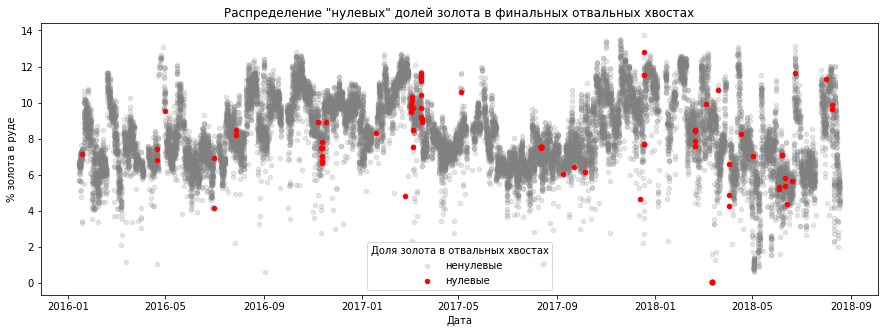

In [31]:
# [Au]=100 in final.output, time distribution
ax = data_full.plot(x='date', 
                    y='rougher.input.feed_au',
                    kind='scatter', c='gray', alpha=0.2, 
                    figsize=(15,5), label='ненулевые')
data_full[data_full['final.output.tail_au'] < 0.001].plot(
    x='date', y='rougher.input.feed_au', kind='scatter', c='r', 
    ax=ax, label='нулевые')

plt.xlabel('Дата')
plt.ylabel('% золота в руде')
plt.legend(title='Доля золота в отвальных хвостах')
plt.title('Распределение "нулевых" долей золота в финальных отвальных хвостах')
plt.show()

Нулевые значения количества золота в отвальных хвостах (0.47% данных) разбросаны по всем данным, а в паре случаев собраны в "кластеры". Это, вероятно, также следствие каких-то технологических ошибок. При этом концентрация золота после флотации, первой и второй очисток ненулевое. Эти ошибки вызывают появление нулевых значений финального коэффициента обогащения, которые стоит обработать перед обучением модели.

*Вывод:* кажется, что как для чернового концентрата, так и для финального сырья нулевые и 100% значения коэффициентов обогащения являются ошибочными и их стоит обработать перед обучением модели.

#### Размер гранул сырья и скорость их подачи

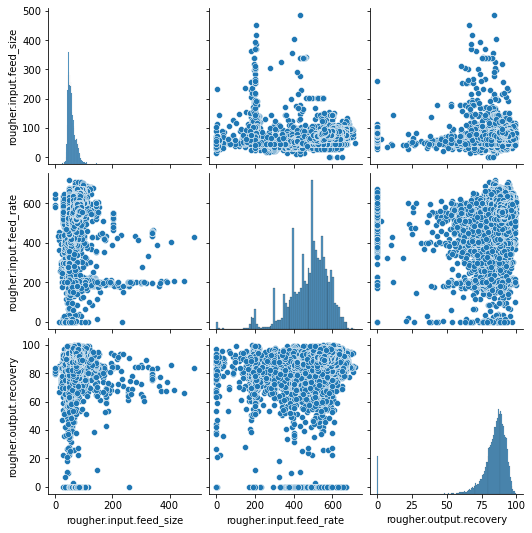

In [32]:
# scatterplots and distribution histograms, rougher
sns.pairplot(data_full[['rougher.input.feed_size',
                        'rougher.input.feed_rate',
                        'rougher.output.recovery']])                        

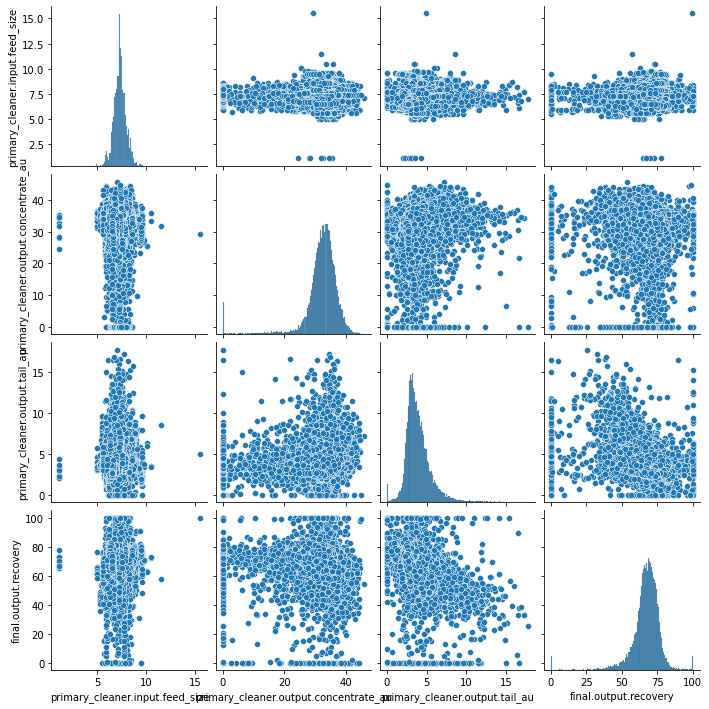

In [33]:
# scatterplots and distribution histograms, primary_cleaner
sns.pairplot(data_full[['primary_cleaner.input.feed_size',
                        'primary_cleaner.output.concentrate_au',
                        'primary_cleaner.output.tail_au',
                        'final.output.recovery']])                        

In [34]:
# descriptive statistics
data_full[['rougher.input.feed_size', 
           'rougher.input.feed_rate',
           'primary_cleaner.input.feed_size',
           'rougher.output.recovery',
           'final.output.recovery']].describe()

rougher.input.feed_size  rougher.input.feed_rate  \
count               19294.0000               19428.0000   
mean                   58.9703                 478.3200   
std                    21.6345                 105.3738   
min                     0.0464                   0.0030   
25%                    47.4351                 416.5255   
50%                    54.6102                 499.4161   
75%                    65.0230                 550.1722   
max                   484.9675                 717.5088   

       primary_cleaner.input.feed_size  rougher.output.recovery  \
count                       19439.0000               19439.0000   
mean                            7.3071                  83.3286   
std                             0.6135                  14.1481   
min                             1.0800                   0.0000   
25%                             6.9400                  81.0380   
50%                             7.2800                  86.1889   
75%                             7.6700                  90.0107   
max                            15.5000                 100.0000   

       final.output.recovery  
count             19439.0000  
mean                 67.0502  
std                  10.1258  
min                   0.0000  
25%                  63.2997  
50%                  68.1727  
75%                  72.6866  
max                 100.0000

*Вывод*: Явно выраженного сильного влияния скорости подачи и размера гранул руды на коэффициент обогащения чернового концентрата не наблюдается, однако прослеживается некоторая тенденция - увеличение этого показателя при снижении скорости подачи и большем размере гранул.<br>
Разброс размера гранул тут большой, в основном размер гранул около 60, и, как правило, не превышает 100, но есть выбросы и до почти 500, а минимальные значения около 0. Скорость подачи сырья в большинстве случаев от 200 до 600 (но есть пики около 0, 200, 400...).<br>
Размер гранул чернового концетрата перед очисткой не оказывает особого влияния ни на концентрацию золота в продукте очистки и отвальных хвостах, ни на финальный коэффициент обогащения. Стоит отметить, что после флотации размер гранул более однородный (стандартное отклонение всего 0.6, в отличие от 22 перед флотацией), он более чем в 8 раз меньше и в среднем составляет около 7.

#### Флотационные реагенты

Сначала посмотрим на стадию **флотации**.

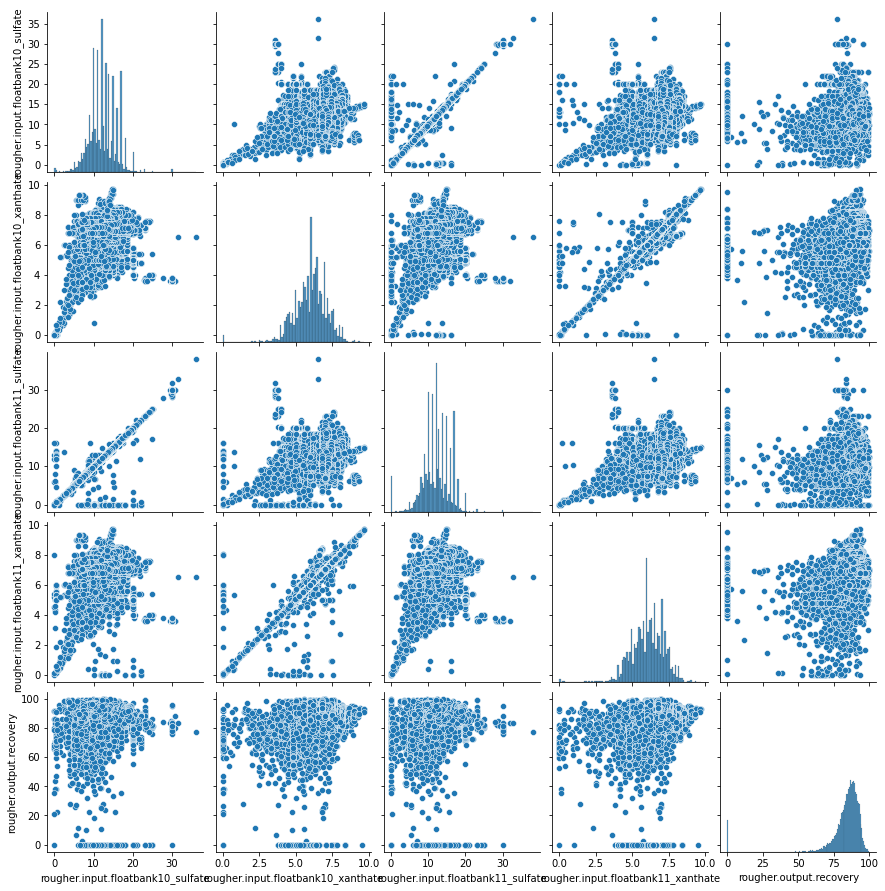

In [35]:
# scatterplots and distribution histograms, rougher
sns.pairplot(data_full[['rougher.input.floatbank10_sulfate',
                        'rougher.input.floatbank10_xanthate',
                        'rougher.input.floatbank11_sulfate',
                        'rougher.input.floatbank11_xanthate',
                        'rougher.output.recovery']]) 

Изучим подробнее влияние флотационных реагентов на эффективность обогащения чернового концентрата.

- Влияние **сульфидов** на зависимость коэффициента обогащения чернового концентрата от доли золота в руде

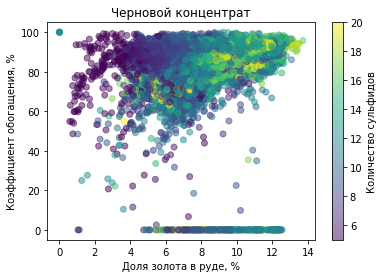

In [36]:
# scatterplot
plt.scatter(data_full['rougher.input.feed_au'], 
            data_full['rougher.output.recovery'],
            c=data_full['rougher.input.floatbank10_sulfate'],
            alpha = .5, cmap = 'viridis', 
            vmin=5, vmax=20
           )
plt.colorbar(label='Количество сульфидов')
plt.title('Черновой концентрат')
plt.xlabel('Доля золота в руде, %')
plt.ylabel('Коэффициент обогащения, %')
plt.show()

- Влияние **ксантогенатов** на зависимость коэффициента обогащения чернового концентрата от доли золота в руде

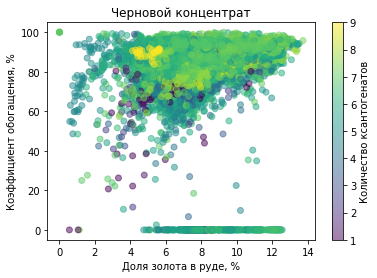

In [37]:
# scatterplot
plt.scatter(data_full['rougher.input.feed_au'], 
            data_full['rougher.output.recovery'],
            c=data_full['rougher.input.floatbank10_xanthate'],
            alpha = .5, cmap = 'viridis', 
            vmin=1, vmax=9
           )
plt.colorbar(label='Количество ксантогенатов')
plt.title('Черновой концентрат')
plt.xlabel('Доля золота в руде, %')
plt.ylabel('Коэффициент обогащения, %')
plt.show()

*Вывод*: количество флотационных реагентов некоторым образом влияет на коэффициент обогащения чернового концентрата, в большей степени - сульфида натрия. Флотационные установки достаточно "похожи" в этом ключе, поэтому одну из них можно исключить.
Количество сульфида натрия и ксантогенатов связаны - чем больше одного реагента, тем больше и другого.
Больше всего с высоким коэффициентом извлечения золота из бедных руд связано количество флотационного реагента сульфида натрия, для таких руд оно минимально.

Посмотрим, как связано количество флотационных реагентов при флотации и перед очисткой, и влияет ли содержание флотационных реагентов перед очисткой на **финальный коэффициент обогащения**.

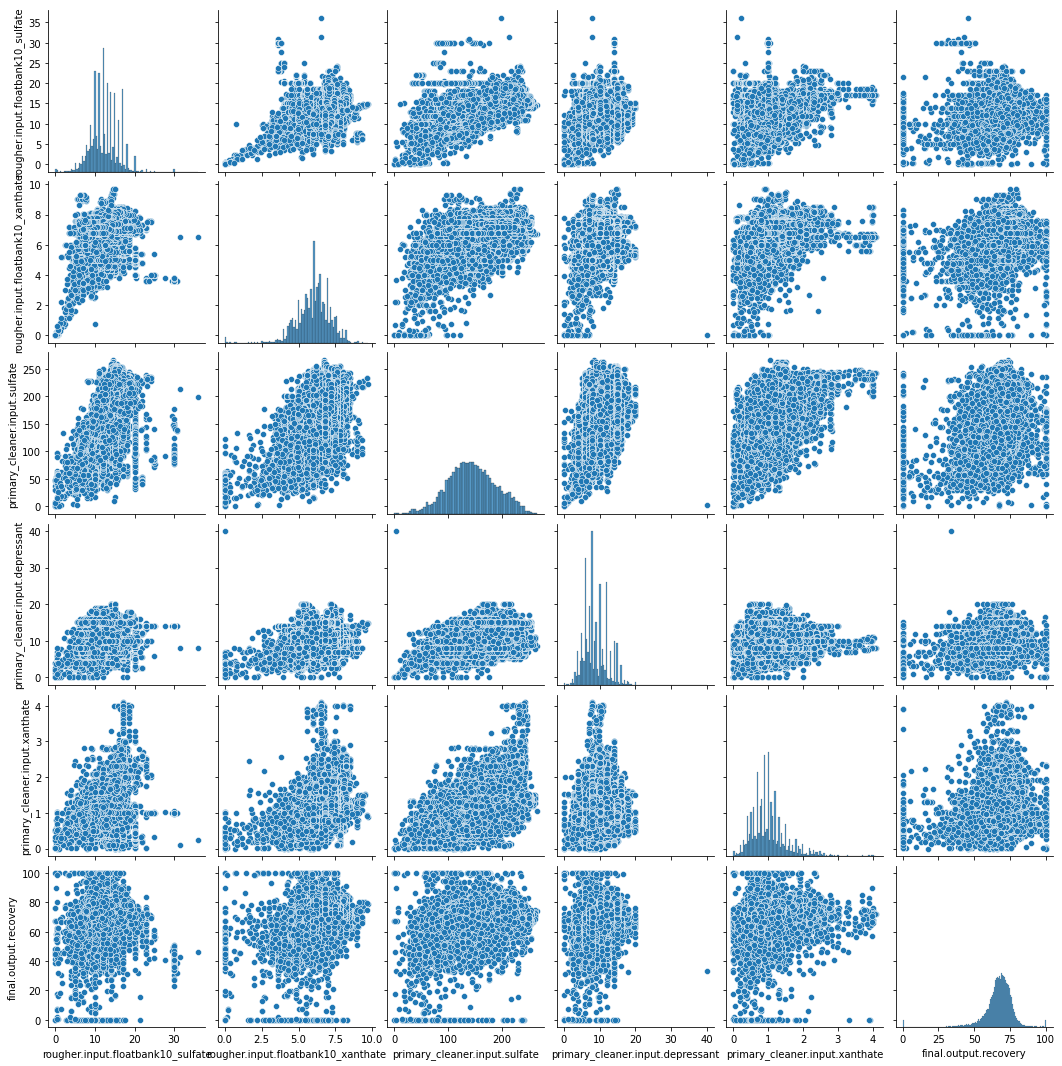

In [38]:
# scatterplots and distribution histograms
sns.pairplot(data_full[['rougher.input.floatbank10_sulfate',
                        'rougher.input.floatbank10_xanthate',
                        'primary_cleaner.input.sulfate',
                        'primary_cleaner.input.depressant',
                        'primary_cleaner.input.xanthate',
                        'final.output.recovery']]) 

- влияние **сульфидов** на зависимость финального коэффициента обогащения от доли золота в черновом концентрате

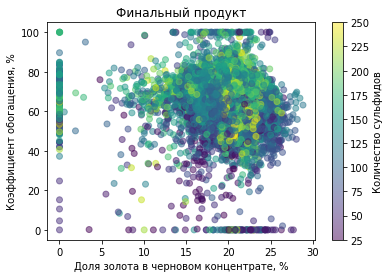

In [39]:
# scatterplot
plt.scatter(data_full['rougher.output.concentrate_au'], 
            data_full['final.output.recovery'],
            c=data_full['primary_cleaner.input.sulfate'],
            alpha = .5, cmap = 'viridis',
            vmin=25, vmax=250
           )
plt.colorbar(label='Количество сульфидов')
plt.title('Финальный продукт')
plt.xlabel('Доля золота в черновом концентрате, %')
plt.ylabel('Коэффициент обогащения, %')
plt.show()

- влияние **ксантогенатов** на зависимость финального коэффициента обогащения от доли золота в черновом концентрате

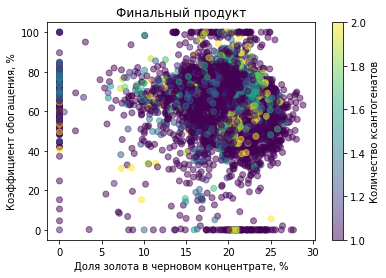

In [40]:
# scatterplot
plt.scatter(data_full['rougher.output.concentrate_au'], 
            data_full['final.output.recovery'],
            c=data_full['primary_cleaner.input.xanthate'],
            alpha = .5, cmap = 'viridis',
            vmin=1, vmax=2
           )
plt.colorbar(label='Количество ксантогенатов')
plt.title('Финальный продукт')
plt.xlabel('Доля золота в черновом концентрате, %')
plt.ylabel('Коэффициент обогащения, %')
plt.show()

*Вывод*: Как правило, чем больше ксантогенатов в черновом концентрате перед очисткой, тем больше сульфида натрия.<br>
Количество сульфида натрия и ксантогенатов в черновом концентрате перед очисткой некоторым образом влияет и на финальный коэффициент обогащения. Влияние ксантогенатов кажется более выраженным. Количество сульфидов во время флотации линейно связано с их количеством перед очисткой и некоторым образом с количеством ксантогенатов перед очисткой.<br>
Не видно зависимости между финальным коэффициентом обогащения и долей золота в черновом концентрате, а также участия в этой взаимосвязи флотационных реагентов.<br>

#### Физические параметры

Посмотрим на влияние объема воздуха и уровня жидкости во флотационных и очистительных установках на коэффициенты обогащения. Сначала посмотрим на стадию флотации и **объем подаваемого воздуха**.

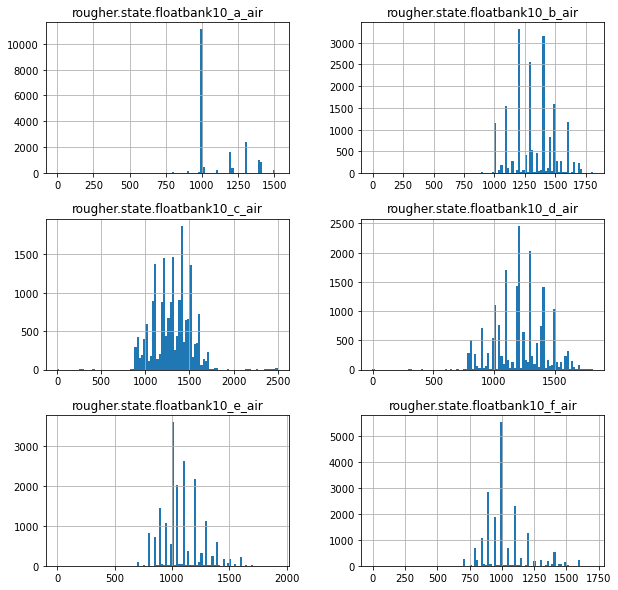

In [41]:
# distribution histograms, rougher
data_full[['rougher.state.floatbank10_a_air',
           'rougher.state.floatbank10_b_air',
           'rougher.state.floatbank10_c_air',
           'rougher.state.floatbank10_d_air',
           'rougher.state.floatbank10_e_air',
           'rougher.state.floatbank10_f_air']].hist(bins=100, figsize=(10, 10))
plt.show()

В целом, разные флотационные установки схожи по объему подаваемого воздуха, за исключением 10_a. Для анализа можно выбрать какую-то одну, например, **10_b** (репрезентативное симметричное распределение).

Посмотрим на **уровень жидкости**.

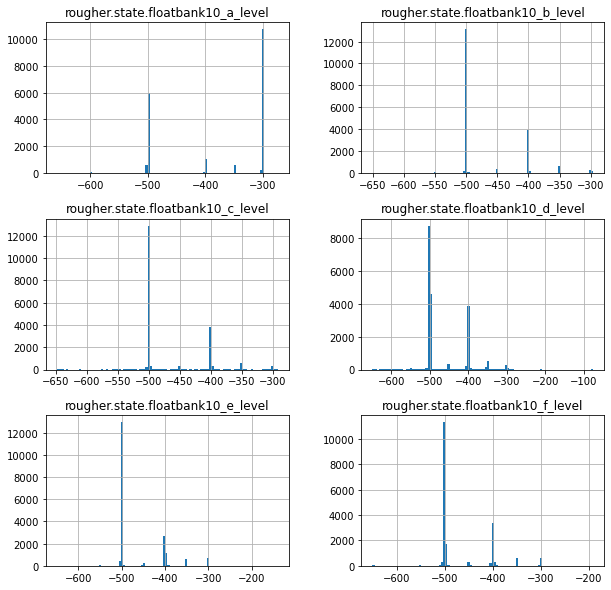

In [42]:
# distribution histograms, rougher
data_full[['rougher.state.floatbank10_a_level',
           'rougher.state.floatbank10_b_level',
           'rougher.state.floatbank10_c_level',
           'rougher.state.floatbank10_d_level',
           'rougher.state.floatbank10_e_level',
           'rougher.state.floatbank10_f_level']].hist(bins=100, figsize=(10, 10))
plt.show()

Флотационные установки схожи по уровню жидкости, опять же, за исключением 10_а. Также выберем одну - **10_b**.

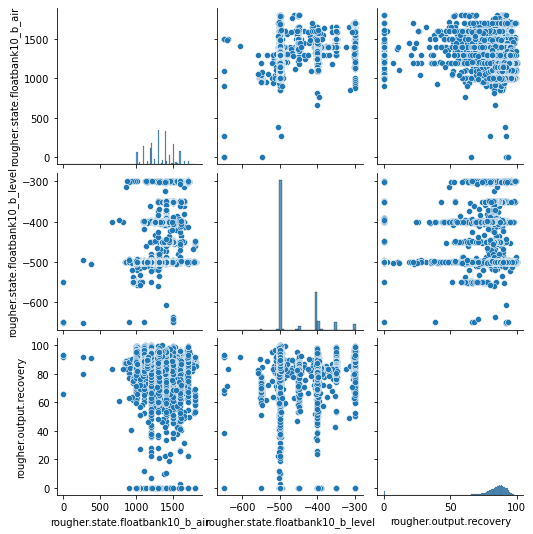

In [43]:
# scatterplots and distribution histograms, rougher
sns.pairplot(data_full[['rougher.state.floatbank10_b_air',
                        'rougher.state.floatbank10_b_level',
                        'rougher.output.recovery']]) 

- Влияние **объема воздуха** на зависимость коэффициента обогащения чернового концентрата от доли золота в руде

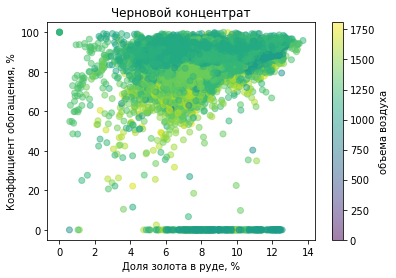

In [44]:
# scatterplot
plt.scatter(data_full['rougher.input.feed_au'], 
            data_full['rougher.output.recovery'],
            c=data_full['rougher.state.floatbank10_b_air'],
            alpha = .5, cmap = 'viridis')

plt.colorbar(label='объема воздуха')
plt.title('Черновой концентрат')
plt.xlabel('Доля золота в руде, %')
plt.ylabel('Коэффициент обогащения, %')
plt.show()

- **Влияние уровня жидкости** на зависимость коэффициента обогащения чернового концентрата от доли золота в руде

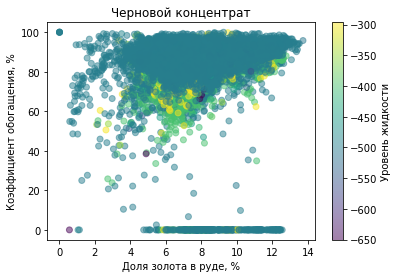

In [45]:
# scatterplot
plt.scatter(data_full['rougher.input.feed_au'], 
            data_full['rougher.output.recovery'],
            c=data_full['rougher.state.floatbank10_b_level'],
            alpha = .5, cmap = 'viridis')

plt.colorbar(label='Уровень жидкости')
plt.title('Черновой концентрат')
plt.xlabel('Доля золота в руде, %')
plt.ylabel('Коэффициент обогащения, %')
plt.show()

*Вывод*: Видно, что больше всего с высоким коэффициентом извлечения золота из бедных руд связано количество флотационного реагента сульфида натрия, для таких руд оно минимально. Таким образом, этот признак будет важным для модели.
Для других "участников" процесса флотации такого влияния не видно.

*Вывод*: кажется, что объем воздуха не сильно влияет на коэффициент обогащения чернового концентрата, а вот с уровнем воды прослеживается некоторая тенденция связи. При более высоких уровнях минимальный коэффициент обогащения чернового концентрата выше.

Посмотрим, влияют ли физические факторы на **финальный коэффициент обогащения**. Поскольку мы видели, что флотационные установки схожи, выберем лишь какую-то одну для каждого этапа очистки.

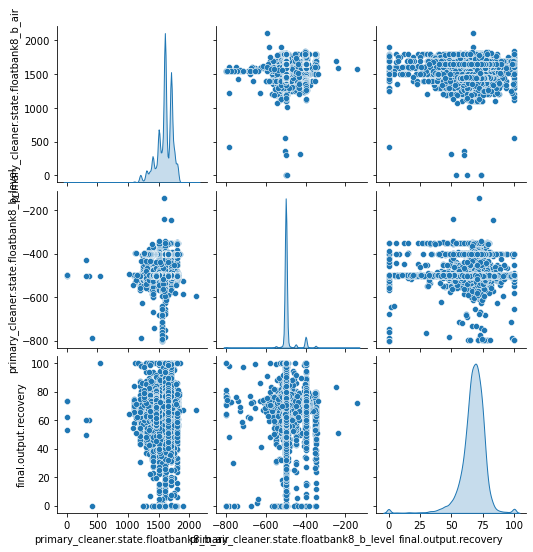

In [46]:
# scatterplots and distribution histograms, primary_cleaner
sns.pairplot(data_full[['primary_cleaner.state.floatbank8_b_air',
                        'primary_cleaner.state.floatbank8_b_level',
                        'final.output.recovery']], diag_kind='kde')

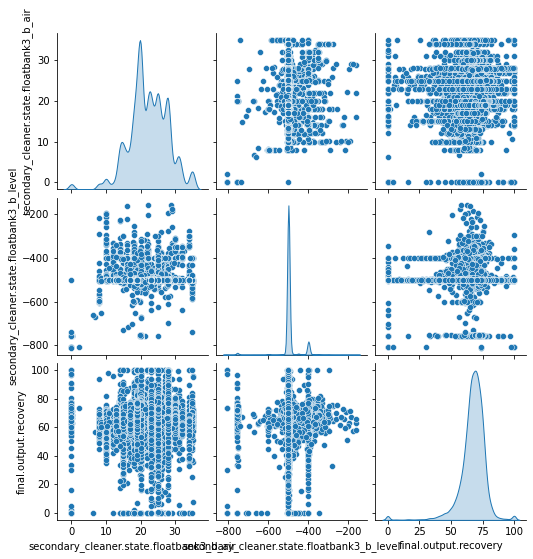

In [47]:
# scatterplots and distribution histograms, secondary_cleaner
sns.pairplot(data_full[['secondary_cleaner.state.floatbank3_b_air',
                        'secondary_cleaner.state.floatbank3_b_level',
                        'final.output.recovery']], diag_kind='kde')

*Вывод*: кажется, что объем воздуха и уровень жидкости в установках на стадиях очистки не сильно влияет на финальный коэффициент обогащения.

#### Доля металлов в руде

Из данных видно, что попутными компонентами этой золотоносной руды являются серебро (*ag*), свинец (*pb*) и, вероятно, зольные компоненты (*sol*). Эффективность работы обогатительных фабрик во многом зависит от качества перерабатываемого сырья.
Посмотрим, как связана доля металлов руде с коэффициентами обогащения золота.

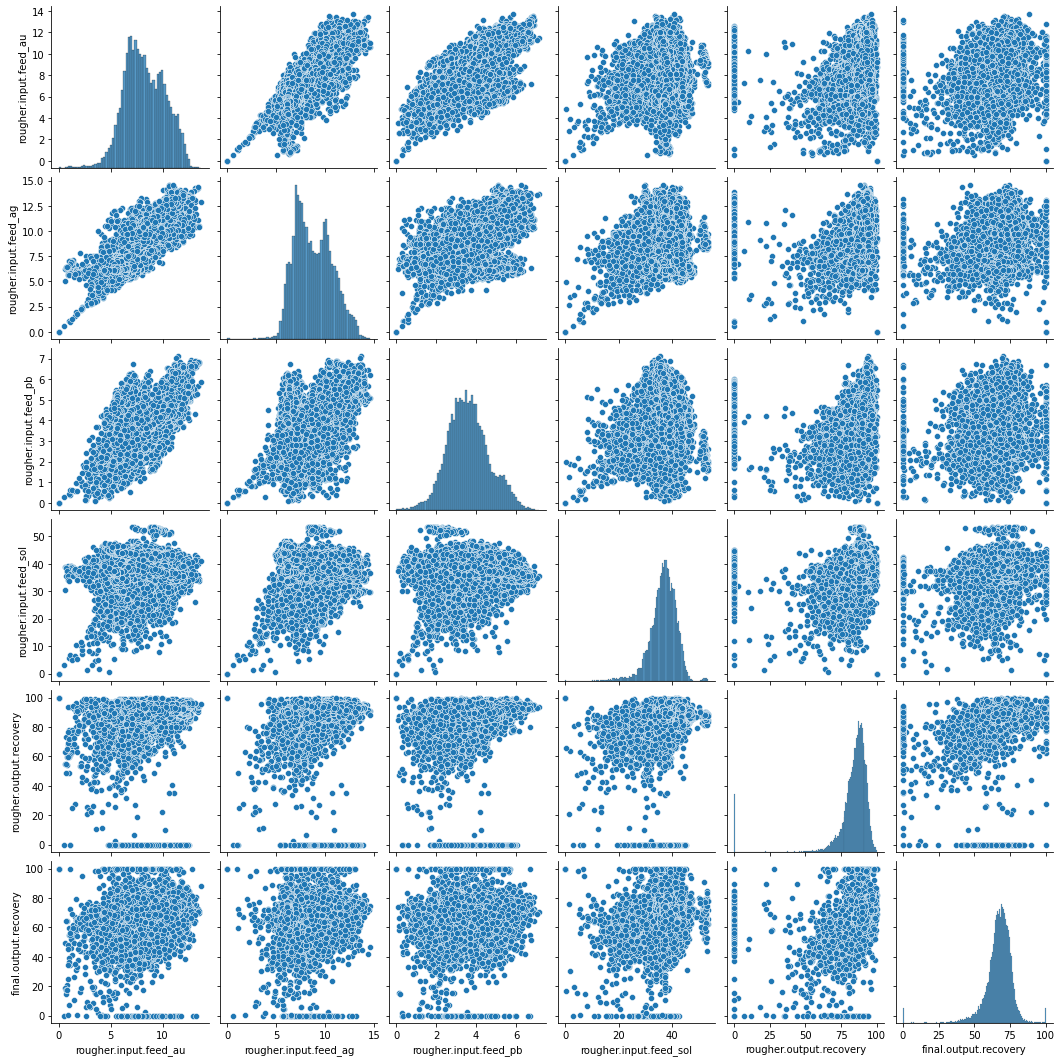

In [48]:
# scatterplots and distribution histograms, rougher
sns.pairplot(data_full[['rougher.input.feed_au',
                        'rougher.input.feed_ag',
                        'rougher.input.feed_pb',
                        'rougher.input.feed_sol',
                        'rougher.output.recovery',
                        'final.output.recovery']])  

In [49]:
# descriptive statistics
data_full[['rougher.input.feed_au',
           'rougher.input.feed_ag',
           'rougher.input.feed_pb',
           'rougher.input.feed_sol']].describe()

rougher.input.feed_au  rougher.input.feed_ag  rougher.input.feed_pb  \
count             19439.0000             19439.0000             19339.0000   
mean                  8.2661                 8.7949                 3.5981   
std                   1.9551                 1.9368                 1.0495   
min                   0.0100                 0.0100                 0.0100   
25%                   6.8544                 7.2380                 2.8873   
50%                   8.1258                 8.5936                 3.5349   
75%                   9.7699                10.2138                 4.2442   
max                  13.7313                14.5960                 7.1426   

       rougher.input.feed_sol  
count              19340.0000  
mean                  36.6951  
std                    5.1454  
min                    0.0100  
25%                   34.2078  
50%                   37.2026  
75%                   40.0391  
max                   53.4777

Мы видели, что есть руды, с более бедным содержанием золота, но достаточно высоким коэффициентом обогащения, проверим предположение, что в отвальных хвостах таких руд содержится меньше золота, а значит оно лучше извлекается.

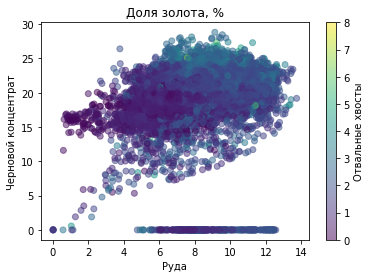

In [50]:
# scatterplot
plt.scatter(data_full['rougher.input.feed_au'], 
            data_full['rougher.output.concentrate_au'],
            c=data_full['rougher.output.tail_au'],
            alpha = .5, cmap = 'viridis',
            vmin=0, vmax=8
           )
plt.colorbar(label='Отвальные хвосты')
plt.title('Доля золота, %')
plt.xlabel('Руда')
plt.ylabel('Черновой концентрат')
plt.show()

Действительно, видно, что для некоторых руд с меньшей долей золота, его доля в "отвальных хвостах" также минимальна (тут, конечно, играет роль и тот факт, если параметры обогащения схожи, что чем меньше золота в руде, тем меньше его будет и в отвальных хвостах).

Посмотрим на коэффициенты корреляции между долями компонентов в руде и коэффициентами обогащения.

In [51]:
# Phik correlation coefficients matrix
phik_overview = data_full[['rougher.input.feed_au',
                       'rougher.input.feed_ag',
                       'rougher.input.feed_pb',
                       'rougher.input.feed_sol',
                       'rougher.output.recovery',
                       'final.output.recovery']].phik_matrix()

interval columns not set, guessing: ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.output.recovery', 'final.output.recovery']


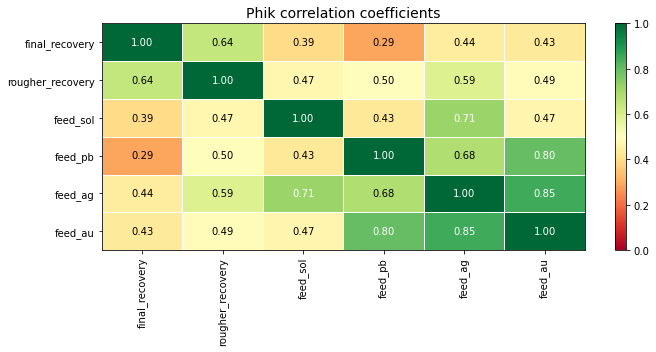

In [52]:
# Plot Phik correlation coefficients matrix
plot_correlation_matrix(phik_overview.values, 
                        x_labels=('feed_au', 'feed_ag', 'feed_pb', 'feed_sol',
                                  'rougher_recovery', 'final_recovery'),
                        y_labels=('feed_au', 'feed_ag', 'feed_pb', 'feed_sol',
                                  'rougher_recovery', 'final_recovery'), 
                        title="Phik correlation coefficients", 
                        figsize=(10, 5),
                        vmin=0, vmax=1)

Как было видно из гистограмм распределения, есть сильная корреляция между количеством золота в руде и количеством серебра, чуть меньшая - с количеством свинца. 
Коэффициент обогащения чернового концентрата имеет умеренную корреляцию с количеством каждого металла и зольного компонента в руде (около 0.5), а финальный коэффициент обогащения более слабо коррелирует с количеством компонентов в руде (наиболее выражено - для золота и серебра).

*Вывод*: Видна некоторая закономерная связь между количеством металлов в руде и коэффициентом обогащения чернового концентрата - чем больше доля металлов в сырье, тем больше коэффициент обогащения. Но связь не четко линейная, видно, что иногда из более бедных руд можно извлечь почти все золото. Вероятно, из некоторого сырья золото извлекается проще, в таком случае меньше золота будет в отвальных хвостах. Вероятно, важную роль тут могут играть другие факторы технологического процесса - количество флотационных реагентов, возможно, физические параметры. Видна такая зависимость - если в руде есть определенная доля цветного металла, то можно рассчитывать на определенный минимальный коэффициент обогащения, в зависимости от руды и условий он может быть значительно выше, но, как праввило, не будет ниже. <br>
На финальный коэффициент обогащения содержание металлов в руде влияет не так сильно, что может быть следствием как раз разной эффективности извлечения металлов из руды. Прослеживается некоторая зависимость для золота (что логично) и серебра, для свинца - почти не видно влияния. Зольные компоненты на коэффициенты обогащения не влияют.

Видно четкую связь доли золота в руде с долями серебра и свинца - чем выше доля золота, тем выше и доля этих металлов. Доля золота и серебра в руде, поступающей на данное предприятие, в среднем около 8% (максимально - около 14%), свинца меньше - около 3.5% (максимально около 7%). Количество зольных компонентов может доходить до 50%, но иногда минимально, около 0.

### Изменение концентрации металлов на различных этапах

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) и зольных компонентов после флотации и двух стадий очитски.

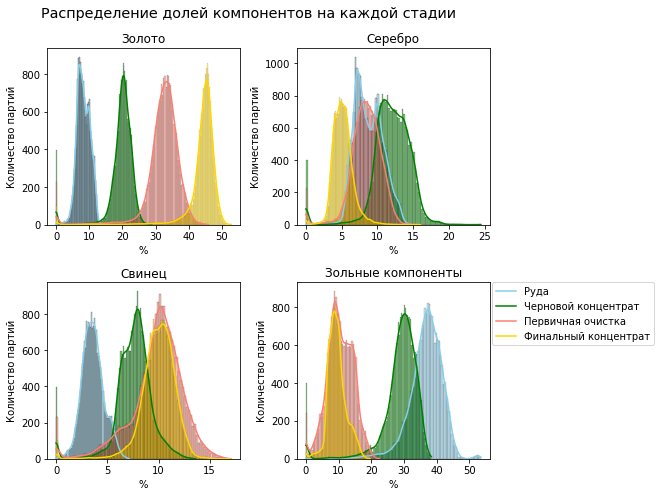

In [53]:
# distribution histograms
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
fig.suptitle("Распределение долей компонентов на каждой стадии", fontsize="x-large")

sns.histplot(data=data_full, x='rougher.input.feed_au', kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=data_full, x='rougher.output.concentrate_au', kde=True, color="green", ax=axs[0, 0])
sns.histplot(data=data_full, x='primary_cleaner.output.concentrate_au', kde=True, color="salmon", ax=axs[0, 0])
sns.histplot(data=data_full, x='final.output.concentrate_au', kde=True, color="gold", ax=axs[0, 0]).set(
    title='Золото', xlabel='%', ylabel='Количество партий')

sns.histplot(data=data_full, x='rougher.input.feed_ag', kde=True, color="skyblue", ax=axs[0, 1])
sns.histplot(data=data_full, x='rougher.output.concentrate_ag', kde=True, color="green", ax=axs[0, 1])
sns.histplot(data=data_full, x='primary_cleaner.output.concentrate_ag', kde=True, color="salmon", ax=axs[0, 1])
sns.histplot(data=data_full, x='final.output.concentrate_ag', kde=True, color="gold", ax=axs[0, 1]).set(
    title='Серебро', xlabel='%', ylabel='Количество партий')

sns.histplot(data=data_full, x='rougher.input.feed_pb', kde=True, color="skyblue", ax=axs[1, 0])
sns.histplot(data=data_full, x='rougher.output.concentrate_pb', kde=True, color="green", ax=axs[1, 0])
sns.histplot(data=data_full, x='primary_cleaner.output.concentrate_pb', kde=True, color="salmon", ax=axs[1, 0])
sns.histplot(data=data_full, x='final.output.concentrate_pb', kde=True, color="gold", ax=axs[1, 0]).set(
    title='Свинец', xlabel='%', ylabel='Количество партий')

sns.histplot(data=data_full, x='rougher.input.feed_sol', kde=True, color="skyblue", ax=axs[1, 1])
sns.histplot(data=data_full, x='rougher.output.concentrate_sol', kde=True, color="green", ax=axs[1, 1])
sns.histplot(data=data_full, x='primary_cleaner.output.concentrate_sol', kde=True, color="salmon", ax=axs[1, 1])
sns.histplot(data=data_full, x='final.output.concentrate_sol', kde=True, color="gold", ax=axs[1, 1]).set(
    title='Зольные компоненты', xlabel='%', ylabel='Количество партий')

plt.tight_layout()
plt.legend(labels=["Руда",
                   "Черновой концентрат",
                   "Первичная очистка",
                   "Финальный концентрат"],
          bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()

Посмотрим на изменение суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

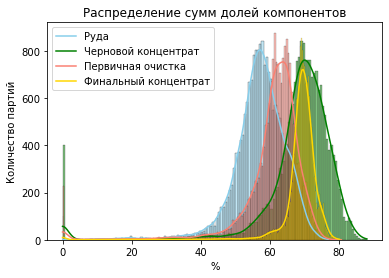

In [54]:
# distribution histograms
sns.histplot(data=data_full, 
             x=data_full[['rougher.input.feed_au',
                          'rougher.input.feed_ag',
                          'rougher.input.feed_pb', 
                          'rougher.input.feed_sol']].sum(axis=1), 
             kde=True, color="skyblue")

sns.histplot(data=data_full, 
             x=data_full[['rougher.output.concentrate_au',
                          'rougher.output.concentrate_ag',
                          'rougher.output.concentrate_pb',
                          'rougher.output.concentrate_sol']].sum(axis=1), 
             kde=True, color="green")

sns.histplot(data=data_full, 
             x=data_full[['primary_cleaner.output.concentrate_au',
                          'primary_cleaner.output.concentrate_ag',
                          'primary_cleaner.output.concentrate_pb',
                          'primary_cleaner.output.concentrate_sol']].sum(axis=1),
             kde=True, color="salmon")
sns.histplot(data=data_full, 
             x=data_full[['final.output.concentrate_au',
                          'final.output.concentrate_ag',
                          'final.output.concentrate_pb',
                          'final.output.concentrate_sol']].sum(axis=1),
             kde=True, color="gold").set(title='Распределение сумм долей компонентов', 
                                         xlabel='%', 
                                         ylabel='Количество партий')

plt.legend(labels=["Руда",
                   "Черновой концентрат",
                   "Первичная очистка",
                   "Финальный концентрат"])
plt.show()

**Вывод**: Видно, что в процессе обогащения концентрация золота увеличивается: в среднем около 10% в руде, около 20% в черновом концентрате, около 30% после первой очистки и более 40% в финальном продукте. Для свинца наблюдается похожая динамика, за исключением того, что вторая очистка уже не приводит к увеличению концентрации. Для серебра картина несколько иная - флотация увеличивает его концентрацию в черновом концентрате, однако последующие очистки снижают его количество в концентратах. Зольные компоненты уменьшаются в доле на каждом этапе технологического процесса, что может говорить о том, что как раз от них и стараются избавиться.

### Обработка аномальных значений

Как видно из гистограмм распределения концентраций металлов и как мы видели в ранее в анализе - в целевых переменных - коэффициентах обогащения - есть аномальные значения, равные 0 и 100. Нулевые значения связанны с нулевой концентрацией золота в черновом и в финальном концентратах соответсвенно. 100% извлечение золота на финальном этапе связано с нулевыми значениями его концентрации в отвальных хвостах. Причина аномалий - скорее всего какие-то технологические ошибки.

Посмотрим, какой процент составляют аномальные значения в тестовой и обучающей выборках.

In [55]:
anom_train=len(data_train[(data_train["rougher.output.recovery"] < 0.001) | 
               (data_train["rougher.output.recovery"] > 99.99) |
               (data_train["final.output.recovery"] < 0.001) |
               (data_train["final.output.recovery"] > 99.99)])/len(data_train)

anom_test=len(data_test[(data_test["rougher.output.recovery"] < 0.001) | 
             (data_test["rougher.output.recovery"] > 99.99) |
             (data_test["final.output.recovery"] < 0.001) |
             (data_test["final.output.recovery"] > 99.99)])/len(data_test)

print('Процент аномальных значений коэффициентов обогащения:')
print(f'Обучающая выборка {anom_train:.2%}')
print(f'Тестовая выборка {anom_test:.2%}')

Процент аномальных значений коэффициентов обогащения:
Обучающая выборка 3.02%
Тестовая выборка 2.87%


Аномальные значения составляют около 3% как в обучающей, так и в тестовой выборках. Поскольку мы не можем заменить значения в целевых переменных - удалим их из обучающей выборки.

In [56]:
# drop 0 and 100 from the training data
data_train = data_train[(
    (data_train["rougher.output.recovery"] > 0.001) & (data_train["rougher.output.recovery"] < 99.99)) & (
    (data_train["final.output.recovery"] > 0.001) & (data_train["final.output.recovery"] < 99.99))]

print('Нулевые или =100% коэффициенты обогащения в обучающей выборке:')
print(len(data_train[(data_train["rougher.output.recovery"] < 0.001) | 
               (data_train["rougher.output.recovery"] > 99.99) |
               (data_train["final.output.recovery"] < 0.001) |
               (data_train["final.output.recovery"] > 99.99)]))

Нулевые или =100% коэффициенты обогащения в обучающей выборке:
0


### Обработка пропущенных значений

В данных имелись пропущенные значения, для построения модели их необходимо обработать.

In [57]:
# number of NaN
print(f'Количество пропущенных значений в train (N={len(data_train)})')
print(data_train.isna().sum()[data_train.isna().sum() > 0]
      .sort_values(ascending=False), '\n')

print(f'Количество пропущенных значений в test (N={len(data_test)})')
print(data_test.isna().sum()[data_test.isna().sum() > 0]
      .sort_values(ascending=False))

Количество пропущенных значений в train (N=13721)
rougher.input.floatbank11_xanthate            374
rougher.state.floatbank10_e_air               368
secondary_cleaner.state.floatbank2_a_air      211
rougher.input.feed_size                       139
rougher.input.feed_pb                         100
primary_cleaner.input.xanthate                 87
rougher.input.feed_sol                         58
rougher.input.floatbank11_sulfate              29
rougher.input.floatbank10_sulfate              19
primary_cleaner.input.depressant               15
rougher.input.feed_rate                         8
secondary_cleaner.state.floatbank2_b_air        7
primary_cleaner.input.sulfate                   7
secondary_cleaner.state.floatbank3_a_air        4
secondary_cleaner.state.floatbank4_a_air        4
rougher.input.floatbank10_xanthate              3
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_a_air          2
primary_cleaner.state.floatbank8_c_air          2


Посмотрим, как были распределены пропуски некоторых признаков во времени на полных данных.

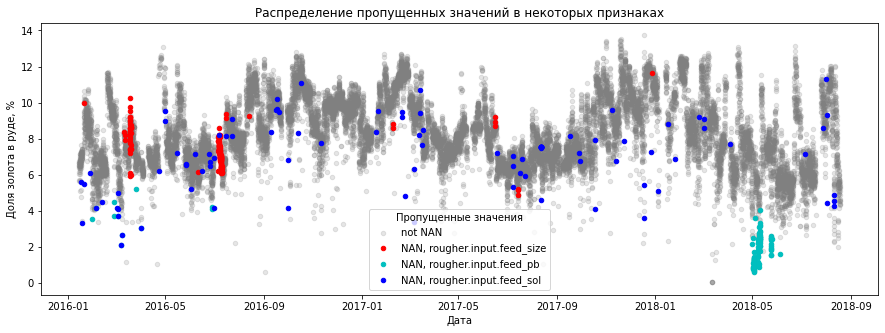

In [58]:
# distribution of NaNs in time
ax = data_full.plot(x='date', 
                    y='rougher.input.feed_au',
                    kind='scatter', c='gray', alpha=0.2, 
                    figsize=(15,5), label='not NAN')
data_full[data_full['rougher.input.feed_size'].isna()].plot(
    x='date', y='rougher.input.feed_au', kind='scatter', c='r', 
    ax=ax, label='NAN, rougher.input.feed_size')
data_full[data_full['rougher.input.feed_pb'].isna()].plot(
    x='date', y='rougher.input.feed_au', kind='scatter', c='c', 
    ax=ax, label='NAN, rougher.input.feed_pb')
data_full[data_full['rougher.input.feed_sol'].isna()].plot(
    x='date', y='rougher.input.feed_au', kind='scatter', c='b', 
    ax=ax, label='NAN, rougher.input.feed_sol')

plt.xlabel('Дата')
plt.ylabel('Доля золота в руде, %')
plt.legend(title='Пропущенные значения')
plt.title('Распределение пропущенных значений в некоторых признаках')
plt.show()

Видно, что для некоторых переменных значения пропущены "кластерами" - вероятно в следствие ошибок в измерениях. Отсутсвие же измерений размера поступающих во флотационную установку гранул сырья распределено равномерно по данным, что может говорить о том, что иногда его, вероятно, затруднительно определить (маленькие гранулы?).

Поскольку отсутвующие данные распределены по датасету или сгруппированы в одних диапазонах значений - заполним их соседними значениями, тем более, что в техническом задании было указано, что соседние показатели обычно схожи. 

In [59]:
# fill NAN in all dataset
data_full = data_full.fillna(method='ffill')
print('Количество пропусков в полном датасете:',
      data_full.isna().sum()[data_full.isna().sum() > 0])

Количество пропусков в полном датасете: Series([], dtype: int64)


Заполним пропуски в тестовых и обучающих данных значениями из полного датасета.

In [60]:
# fill NAN in training and test data
data_train = (data_train
              .set_index('date')
              .fillna(data_full.set_index('date')))

data_test = (data_test
             .set_index('date')
             .fillna(data_full.set_index('date')))

In [61]:
print('Количество пропусков в обучающих данных:', 
      data_train.isna().sum()[data_train.isna().sum() > 0])
print('Количество пропусков в тестовых данных:', 
      data_test.isna().sum()[data_test.isna().sum() > 0])

Количество пропусков в обучающих данных: Series([], dtype: int64)
Количество пропусков в тестовых данных: Series([], dtype: int64)


## Исследование моделей

Для прогнозирования коэффициентов обогащения проверим две модели - линейную регрессию и случайный лес. Будем проверять модели отдельно для прогнозирования коэффициентов обогощения чернового и финального концентратов.

В качестве метрики качества моделей будем использовать симметричное среднее абсолютное процентное отклонение, sMAPE, одинаково учитывающее масштаб и целевого признака, и предсказания.

Напишем функции для вычисления sMAPE и итогового sMAPE, обобщающего качество модели для предсказания коэффициентов обогащения чернового и финального концентратов.

In [62]:
# define function to calculate Symmetric Mean Absolute Percentage Error (sMAPE)
def smape_score(y_true, y_pred):
    y_true = np.array(y_true)
    res = np.mean(
        np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred))*0.5)
    )*100
    return res

In [63]:
# define function to calculate final sMAPE
def final_smape(smape_rougher, smape_final):
    return (smape_rougher*0.25 + smape_final*0.75)
    

###  Прогноз коэффициента обогащения чернового концентрата

**Подготовка данных для моделей**

Основываясь на проведенном анализе признаков, для построения модели исключим: 
- `rougher.input.feed_ag`, так как он практически "повторяет" `rougher.input.feed_au`
- `rougher.input.floatbank10_xanthate`, так как он коррелирует с `rougher.input.floatbank10_sulfate`, а последний как кажется, имеет большую связь с целевым признаком.
- `rougher.input.floatbank11`, так как они практически "повторяют" `rougher.input.floatbank10`
- `rougher.state.floatbank10_a, c, d, e, f`, так как они практически "повторяют" `rougher.state.floatbank10_b`

In [64]:
# training data for "Rougher recovery" model
data_train_rougher = data_train[['rougher.input.feed_pb',
                                 'rougher.input.feed_rate',
                                 'rougher.input.feed_size',
                                 'rougher.input.feed_sol',
                                 'rougher.input.feed_au',
                                 'rougher.input.floatbank10_sulfate',
                                 'rougher.state.floatbank10_b_air',
                                 'rougher.state.floatbank10_b_level',
                                 'rougher.output.recovery']]
data_train_rougher.shape

(13721, 9)

In [65]:
# test data for "Rougher recovery" model
data_test_rougher = data_test[list(data_train_rougher)]
data_test_rougher.shape

(5290, 9)

In [66]:
# targets and features
x_train_rougher = data_train_rougher.drop('rougher.output.recovery', axis=1)
y_train_rougher = data_train_rougher['rougher.output.recovery']

x_test_rougher = data_test_rougher.drop('rougher.output.recovery', axis=1)
y_test_rougher = data_test_rougher['rougher.output.recovery']

#### Линейная регрессия

In [67]:
# Create the model
model_lr = LinearRegression()

# Cross-validation
scores_lr = cross_val_score(model_lr, x_train_rougher, y_train_rougher, cv=5, 
                            scoring=make_scorer(smape_score))

In [68]:
score_lr = scores_lr.mean()
print(f'Среднee sMAPE: {score_lr:.2f} со стандартным отклонением {scores_lr.std():.2f}')

Среднee sMAPE: 6.73 со стандартным отклонением 1.73


#### Случайный лес

In [69]:
# Create the model
model_rf = RandomForestRegressor(random_state=123)

# Hyperparameters to check
params = {'max_depth': range(1, 30), 'n_estimators': range(10, 200, 10)}

In [70]:
# Cross-validation
grid_model_rougher = RandomizedSearchCV(model_rf, params, 
                                        n_jobs=-1, 
                                        random_state=123, cv=5,
                                        scoring=make_scorer(smape_score, greater_is_better=False))

# Fit the model on the training data
grid_model_rougher.fit(x_train_rougher, y_train_rougher)

print(f'Гиперпараметры лучшей модели: {grid_model_rougher.best_params_}')
print(f'sMAPE: {abs(grid_model_rougher.best_score_):.2f}')

Гиперпараметры лучшей модели: {'n_estimators': 190, 'max_depth': 8}
sMAPE: 6.54


#### Cлучайная модель

In [71]:
# Create the dummy model
dummy_regr = DummyRegressor(strategy="mean")

# Cross-validation
scores_dr = cross_val_score(dummy_regr, x_train_rougher, y_train_rougher, cv=5, 
                            scoring=make_scorer(smape_score, greater_is_better=False))

score_dr = scores_dr.mean()

print(f'sMAPE случайной модели: {abs(score_dr):.2f} со стандартным отклонением {scores_dr.std():.2f}')

sMAPE случайной модели: 7.80 со стандартным отклонением 1.70


**Вывод**: Случайный лес для регрессии из 190 деревьев глубиной 8 показал самую маленькую ошибку, она почти на 1.5% меньше, чем у случайной модели.

### Прогноз коэффициента обогащения финального продукта

**Подготовка данных для моделей**

Основываясь на проведенном анализе признаков, для построения модели возьмем признаки из первой модели, кроме самого "неважного" - `rougher.input.feed_rate`, а также не будем брать физические параметры флотации - уровень жидкости и объем воздуха, их возьмем из второго этапа очистки.

Кроме этого, из этапов очистки добавим `primary_cleaner.input.xanthate`, `primary_cleaner.input.sulfate`, физические параметры `secondary_cleaner.state.floatbank3_b_air, level`.

Не будем также включать: `primary_cleaner.input.feed_size`, так как размеры достаточно однородные и не видно их влияния, `primary_cleaner.input.depressant`, так как его влияния не видно.

In [72]:
# training data for "Final recovery" model
data_train_final = data_train[['primary_cleaner.input.sulfate',
                               'primary_cleaner.input.xanthate',
                               'rougher.input.feed_pb',
                               'rougher.input.feed_size',
                               'rougher.input.feed_sol',
                               'rougher.input.feed_au',
                               'rougher.input.floatbank10_sulfate',
                               'secondary_cleaner.state.floatbank3_b_air',
                               'secondary_cleaner.state.floatbank3_b_level',
                               'final.output.recovery']]
data_train_final.shape

(13721, 10)

In [73]:
# test data for "Final recovery" model
data_test_final = data_test[list(data_train_final)]
data_test_final.shape

(5290, 10)

In [74]:
# targets and features
x_train_final = data_train_final.drop('final.output.recovery', axis=1)
y_train_final = data_train_final['final.output.recovery']

x_test_final = data_test_final.drop('final.output.recovery', axis=1)
y_test_final = data_test_final['final.output.recovery']

#### Линейная регрессия

In [75]:
# Create the model
model_lr = LinearRegression()

# Cross-validation
scores_lr = cross_val_score(model_lr, x_train_final, y_train_final, cv=5,
                            scoring=make_scorer(smape_score, greater_is_better=False))

In [76]:
score_lr = scores_lr.mean()
print(f'Средняя оценка качества модели: {abs(score_lr):.2f} со стандартным отклонением {scores_lr.std():.2f}')

Средняя оценка качества модели: 9.46 со стандартным отклонением 1.51


#### Случайный лес

In [77]:
# Create the model
model_rf = RandomForestRegressor(random_state=123)

# Hyperparameters to check
params = {'max_depth': range(1, 30), 'n_estimators': range(10, 200, 10)}

In [78]:
# Cross-validation
grid_model = RandomizedSearchCV(model_rf, params, n_jobs=-1, random_state=123, cv=5,
                                scoring=make_scorer(smape_score, greater_is_better=False))

# Fit the model on the training data
grid_model.fit(x_train_final, y_train_final)

print(f'Гиперпараметры лучшей модели: {grid_model.best_params_}')
print(f'sMAPE: {abs(grid_model.best_score_):.2f}')

Гиперпараметры лучшей модели: {'n_estimators': 70, 'max_depth': 5}
sMAPE: 9.95


#### Cлучайная модель

In [79]:
# Create the dummy model
dummy_regr = DummyRegressor(strategy="mean")

# Cross-validation
scores_dr = cross_val_score(dummy_regr, x_train_final, y_train_final, cv=5, 
                            scoring=make_scorer(smape_score, greater_is_better=False))

score_dr = scores_dr.mean()

print(f'sMAPE случайной модели: {abs(score_dr):.2f} со стандартным отклонением {scores_dr.std():.2f}')

sMAPE случайной модели: 10.30 со стандартным отклонением 0.94


**Вывод:**
Самую маленькую ошибку показала модель Линейной регрессии, sMAPE=9.46, что почти на 1% меньше, чем у случайной модели.

## Тестирование моделей

### Предсказание коэффициента обогащения для чернового концентрата

In [80]:
# Create the model
model_rougher = RandomForestRegressor(max_depth=8, n_estimators=190, random_state=12345)

# Fit the model on the training data
model_rougher.fit(x_train_rougher, y_train_rougher)

RandomForestRegressor(max_depth=8, n_estimators=190, random_state=12345)

In [81]:
# Make predictions on the test data
pred_test_rougher = model_rougher.predict(x_test_rougher)

In [82]:
# Create the dummy model
dummy_regr = DummyRegressor(strategy="mean")
# Fit the model on the training data
dummy_regr.fit(x_train_rougher, y_train_rougher)
# Make predictions on the test data
pred_dummy_rougher = dummy_regr.predict(x_test_rougher)

In [83]:
# Evaluate the model
smape_model_rougher = smape_score(y_test_rougher, pred_test_rougher)
smape_dummy_rougher = smape_score(y_test_rougher, pred_dummy_rougher)

print('sMAPE:', round(smape_model_rougher, 4))
print('sMAPE случайной модели:', round(smape_dummy_rougher, 4))

sMAPE: 8.1025
sMAPE случайной модели: 9.0755


Посмотрим на то, какие признаки были важными для принятия решения моделью:

Text(0.5, 0, '')

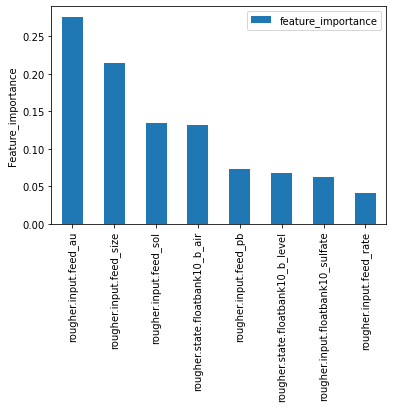

In [84]:
# Importance of the features for RandomForest
feature_importances = pd.DataFrame(
    {'features': list(x_train_rougher.columns),
     'feature_importance': model_rougher.feature_importances_})

# plot feature importances
feature_importances.sort_values(by='feature_importance', ascending=False).plot(kind='bar', x='features')
plt.ylabel('Feature_importance')
plt.xlabel('')

**Вывод**: Качество модели, проверенное на тестовой выборке получилось выше, чем у случайной модели. На основании данной модели можно предсказывать значения коэффициентов обогащения чернового концентрата, ошибаясь лишь в 8% случаев. Самым важным признаком для предсказания является содержание золота в руде, что логично. Важен также размер гранул сырья, а вот скорость их подачи большой роли не играет.

### Предсказание коэффициента обогащения для финального продукта

In [85]:
# Create the model
model_final = LinearRegression()

# Fit the model on the training data
model_final.fit(x_train_final, y_train_final)

LinearRegression()

In [86]:
# Make predictions on the test data
pred_test_final = model_final.predict(x_test_final)

In [87]:
# Create the dummy model
dummy_regr = DummyRegressor(strategy="mean")
# Fit the model on the training data
dummy_regr.fit(x_train_final, y_train_final)
# Make predictions on the test data
pred_dummy_final = dummy_regr.predict(x_test_final)

In [88]:
# Evaluate the model
smape_model_final = smape_score(y_test_final, pred_test_final)
smape_dummy_final = smape_score(y_test_final, pred_dummy_final)

print('sMAPE:', round(smape_model_final, 4))
print('sMAPE случайной модели:', round(smape_dummy_final, 4))

sMAPE: 9.4904
sMAPE случайной модели: 10.1791


**Вывод**: Качество модели, проверенное на тестовой выборке получилось почти на 1% выше, чем у случайной модели. На основании данной модели можно предсказывать финальные значения коэффициентов обогащения, ошибаясь лишь в 9,5% случаев. 

### Итоговая метрика
Рассчитаем итоговую оценку качества моделей.

In [89]:
f'Итоговая sMAPE: {final_smape(smape_model_rougher, smape_model_final):.2f}'

'Итоговая sMAPE: 9.14'

## Общий вывод:

Из данных видно, что руды, используемые на данном предприятии, являются комплексными - в них содержится поровну золота и серебра, а также свинец, причем их соотношение как правило линейно зависимо - чем больше золота в руде, тем больше и серебра и свинца. Содержание золота не очень высокое - 8%, но из более бедных руд иногда удается извлечь больше золота. Это указывает не только на то, что руды отличаются между собой, но и на то, что стоит обращать внимание на процесс обогащения и его параметры, возможно, они также могут значимо влиять на коэффициенты обогащения. Например, более бедные руды также может быть выгодно использовать - некоторые из них могут иметь высокий коэффициент обогащения с использованием низкого количества флотационного реагента сульфида натрия, что может снижать затраты обогащения.

С каждой стадией технологического процесса доля золота "на выходе" повышается примерно на 10%, для других металлов такой четкой зависимости нет, что говорит о том, что процесс оптимизирован под обогащение золота. Возможно, стоит дополнительно отдельно проанализировать его содержание в отвальных хвостах и связь этого параметра с другими.

Коэффициент обогащения чернового концентрата как правило составляет 80-90%, а финального концентрата чуть ниже - 60-70%. Из анализа данных видно, что больше всего на коэффициент обогащения чернового концентрата влияет доля золота и других металлов в руде, некоторое влияние имеют и размер гранул сырья, количество флотационных реагентов. На финальный коэффициент обогащения также влияет концентрация металлов в руде, но в меньшей степени, плюс, содержание флотационных реагентов в черновом концентрате перед очисткой.

В данных есть пропущенные и аномальные значения. Так, концентрация золота на "выходе" технологического этапа или в отвальных хвостах могла равняться 0. Проанализировав такие случаи кажется, что это связано с какими-то технологическими ошибками, а не особенностями сырья. Для обучения модели пропущенные значения были заменены на ближайшие соседние, а аномальные в обучающей выборке - удалены.

Анализ данных позволил разработать модели для предсказания значений коэффициентов обогащения в черновом и финальном концентратах. Итоговая оценка качества моделей составляет около 9%, то есть используя такой прогноз мы будем ошибаться примерно в 9% случаев. Разработка модели машинного обучения для предсказания коэффициента восстановления золота из золотосодержащей руды поможет оценивать перспективность руды и оптимизировать параметры ее обогащения для более эффективного производства.